# 1. Data Ingestion & Hygiene

In [3]:
import os
import sys
import gc
import shutil  # Added for file copy fallback
import logging
import psutil
import json
from pathlib import Path
from datetime import datetime, timezone
from typing import Optional, List, Dict

# ==============================================================================
# Global Constants & Path Definition
# ==============================================================================


DEFAULT_RAW_DATA_PATH = Path("/content/drive/MyDrive/btc_data.csv")

class QuantConfig:
    """
    Global Quantitative Configuration Manager (Singleton).
    Acting as the 'Central Nervous System' for the strategy execution.
    """
    _instance: Optional['QuantConfig'] = None

    def __new__(cls):
        if cls._instance is None:
            cls._instance = super(QuantConfig, cls).__new__(cls)
            cls._instance._init_config()
        return cls._instance

    def _init_config(self):
        self.PROJECT_NAME = "BTC_HFT_FASANARA"
        self.IS_COLAB = "google.colab" in sys.modules

        # Root Directory Setup
        if self.IS_COLAB:
            self.ROOT = Path(f"/content/drive/MyDrive/{self.PROJECT_NAME}")
        else:
            self.ROOT = Path.cwd()

        # Standard Directory Structure
        self.DIRS = {
            "src": ["data", "alpha", "execution", "analytics", "portfolio", "stability", "engine", "config", "utils"],
            "data": ["raw", "processed", "cache", "feature_zoo"],
            "outputs": ["logs", "backtests", "plots", "models"]
        }

        # Core Strategy Parameters (Hyperparameters)
        self.STRATEGY_PARAMS = {
            "default_horizon": "30s",  # Optimized via V3 Analysis
            "fee_bps": 2.0,            # Binance VIP0 Taker
            "lambda_vol": 1.2          # Dynamic Threshold Multiplier
        }

    def setup_filesystem(self, raw_source_path: Path):
        """
        Initialize the physical file system and data linkage.
        Implements a fallback mechanism for OS-specific symlink constraints.
        """
        for root_dir, sub_dirs in self.DIRS.items():
            for sub in sub_dirs:
                path = self.ROOT / root_dir / sub
                path.mkdir(parents=True, exist_ok=True)

        # Data Linkage Logic (Symlink -> Copy Fallback)
        raw_target = self.ROOT / "data/raw/full_month_btc.csv"

        # Only proceed if source exists and target doesn't
        if raw_source_path.exists() and not raw_target.exists():
            try:
                os.symlink(str(raw_source_path), str(raw_target))
                print(f"[System] Symlinked data to {raw_target}")
            except OSError:
                # Fallback for Windows without Admin privileges
                print("[System] Symlink failed (OS permission), falling back to COPY...")
                shutil.copy(str(raw_source_path), str(raw_target))
                print(f"[System] Copied data to {raw_target}")

# ------------------------------------------------------------------------------
# Resource Guard & Performance Tools
# ------------------------------------------------------------------------------
class ResourceGuard:
    @staticmethod
    def get_ram_usage() -> float:
        """Returns current process RSS memory in MB."""
        return psutil.Process(os.getpid()).memory_info().rss / 1024**2

    @staticmethod
    def memory_check(threshold_mb: float = 10000) -> tuple[bool, int, float]:
        """
        Quant-grade memory watchdog.
        Triggers aggressive GC if RSS exceeds threshold.
        """
        usage = ResourceGuard.get_ram_usage()
        if usage > threshold_mb:
            before = usage
            n = gc.collect()
            after = ResourceGuard.get_ram_usage()
            return True, n, before - after
        return False, 0, 0.0

# ------------------------------------------------------------------------------
# Logger Factory
# ------------------------------------------------------------------------------
def setup_quant_logger(root_path: Path):
    """
    Configures a production-grade logger with proper formatting and file rotation.
    """
    log_dir = root_path / "outputs/logs"
    # Ensure dir exists (redundant safety check)
    log_dir.mkdir(parents=True, exist_ok=True)

    log_file = log_dir / f"hft_research_{datetime.now(timezone.utc):%Y%m%d}.log"

    logger = logging.getLogger("QuantEngine")
    logger.setLevel(logging.INFO)

    # Prevent duplicate handlers in interactive environments (Jupyter/Colab)
    if logger.hasHandlers():
        logger.handlers.clear()

    formatter = logging.Formatter(
        '[%(asctime)s | %(name)s | %(levelname)s] %(message)s',
        datefmt='%Y-%m-%d %H:%M:%S'
    )

    # File Handler
    fh = logging.FileHandler(log_file)
    fh.setFormatter(formatter)

    # Stream Handler (Stdout)
    sh = logging.StreamHandler(sys.stdout)
    sh.setFormatter(formatter)

    logger.addHandler(fh)
    logger.addHandler(sh)

    return logger

# ------------------------------------------------------------------------------
# Bootstrap Entry Point
# ------------------------------------------------------------------------------
def bootstrap(raw_data_path: str = None):
    # 1. Instantiate Configuration
    cfg = QuantConfig()

    # Resolve raw data path
    if raw_data_path:
        r_path = Path(raw_data_path)
    else:
        # Fallback to current directory or a default location
        r_path = Path("btc_data.csv")

    # 2. Setup Filesystem
    cfg.setup_filesystem(raw_source_path=r_path)

    # 3. Inject Source Path
    src_path = str(cfg.ROOT / "src")
    if src_path not in sys.path:
        sys.path.insert(0, src_path)

    # 4. Initialize Logger
    logger = setup_quant_logger(cfg.ROOT)

    logger.info("="*60)
    logger.info(f" QUANT SYSTEM BOOTSTRAP: {cfg.PROJECT_NAME}")
    logger.info(f" PROJECT ROOT: {cfg.ROOT}")
    logger.info(f" DATA SOURCE: {r_path}")
    logger.info("="*60)

    # 5. Initial Resource Report
    ram_used = ResourceGuard.get_ram_usage()
    logger.info(f" Initial System RAM: {ram_used:.1f} MB")

    return cfg, logger

if __name__ == "__main__":
    # Example usage: Pass the actual path to your CSV here
    # If running in Colab, change this path to where your uploaded file is
    config, logger = bootstrap(raw_data_path="/content/drive/MyDrive/Bitcoin_Strategy/btc_data.csv")

[2026-01-07 12:00:27 | QuantEngine | INFO] ============================================================


INFO:QuantEngine:============================================================


[2026-01-07 12:00:27 | QuantEngine | INFO]  QUANT SYSTEM BOOTSTRAP: BTC_HFT_FASANARA


INFO:QuantEngine: QUANT SYSTEM BOOTSTRAP: BTC_HFT_FASANARA


[2026-01-07 12:00:27 | QuantEngine | INFO]  PROJECT ROOT: /content/drive/MyDrive/BTC_HFT_FASANARA


INFO:QuantEngine: PROJECT ROOT: /content/drive/MyDrive/BTC_HFT_FASANARA


[2026-01-07 12:00:27 | QuantEngine | INFO]  DATA SOURCE: /content/drive/MyDrive/Bitcoin_Strategy/btc_data.csv


INFO:QuantEngine: DATA SOURCE: /content/drive/MyDrive/Bitcoin_Strategy/btc_data.csv


[2026-01-07 12:00:27 | QuantEngine | INFO] ============================================================


INFO:QuantEngine:============================================================


[2026-01-07 12:00:27 | QuantEngine | INFO]  Initial System RAM: 119.8 MB


INFO:QuantEngine: Initial System RAM: 119.8 MB


In [4]:
import os
import sys
import logging
from pathlib import Path
from typing import Optional, Dict

class EnvConfig:
    """
    High-Frequency Trading Environment Configuration Manager.
    Optimized for cross-platform deployment (Colab/Local/Docker).

    Attributes (Dynamically Bound):
        raw (Path): Raw data directory.
        processed (Path): Processed data directory.
        cache (Path): Temporary cache directory.
        feature_zoo (Path): Extracted alpha factors storage.
        logs (Path): System and trading logs.
        backtests (Path): Strategy backtest results.
        models (Path): Serialized ML model weights.
    """
    _instance: Optional['EnvConfig'] = None
    PROJECT_NAME = "BTC_HFT_FASANARA"
    IS_COLAB = "google.colab" in sys.modules

    # Explicit type hints for IDE autocompletion
    src: Path
    data: Path
    raw: Path
    processed: Path
    cache: Path
    feature_zoo: Path
    logs: Path
    backtests: Path
    models: Path

    def __new__(cls):
        if cls._instance is None:
            cls._instance = super(EnvConfig, cls).__new__(cls)
            cls._instance._initialized = False
        return cls._instance

    def __init__(self):
        if getattr(self, "_initialized", False):
            return

        self.root = self._resolve_root()
        self._setup_paths()
        self._initialized = True

    def _setup_paths(self):
        """Standardizes the quantitative research directory tree."""
        self.src = self.root / "src"
        self.data = self.root / "data"
        self.outputs = self.root / "outputs"

        self.sub_dirs: Dict[str, Path] = {
            "raw": self.data / "raw",
            "processed": self.data / "processed",
            "cache": self.data / "cache",
            "feature_zoo": self.data / "feature_zoo",
            "logs": self.outputs / "logs",
            "backtests": self.outputs / "backtests",
            "models": self.outputs / "models"
        }

        # Dynamic attribute binding for ENTJ-style efficiency
        for name, path in self.sub_dirs.items():
            setattr(self, name, path)

    @classmethod
    def _resolve_root(cls) -> Path:
        """Determines project root using hierarchical priority."""
        # Priority 1: Environment Variable (CI/CD standard)
        env_root = os.getenv("QUANT_ROOT")
        if env_root:
            return Path(env_root)

        # Priority 2: Google Colab specific pathing
        if cls.IS_COLAB:
            return Path(f"/content/drive/MyDrive/{cls.PROJECT_NAME}")

        # Priority 3: Heuristic Search based on call stack
        try:
            # Optimal for .py scripts
            start_path = Path(__file__).resolve().parent
        except NameError:
            # Fallback for Interactive Notebooks
            start_path = Path.cwd()

        for parent in [start_path] + list(start_path.parents):
            if (parent / "src").exists() or (parent / ".git").exists():
                return parent
        return start_path

    def bootstrap(self, verbose: bool = True):
        """Initializes physical infrastructure and system paths."""
        # Create directory structure
        for path in self.sub_dirs.values():
            path.mkdir(parents=True, exist_ok=True)

        # High-priority source injection
        src_str = str(self.src)
        if src_str not in sys.path:
            sys.path.insert(0, src_str)

        if verbose:
            self._log_status()

    def _log_status(self):
        """System status report."""
        print("-" * 50)
        print(f"SYSTEM STATUS: {self.PROJECT_NAME} | ACTIVE")
        print(f"ROOT_DIR: {self.root}")
        print(f"SYS_PATH: Source Injected at index 0")
        print("-" * 50)

# Implementation
config = EnvConfig()
config.bootstrap()

--------------------------------------------------
SYSTEM STATUS: BTC_HFT_FASANARA | ACTIVE
ROOT_DIR: /content/drive/MyDrive/BTC_HFT_FASANARA
SYS_PATH: Source Injected at index 0
--------------------------------------------------


# 1.1 Raw data




In [ ]:
import polars as pl
from pathlib import Path

def process_raw_btc_data(config):

    raw_csv_source = Path("/content/drive/MyDrive/BTC_HFT_FASANARA/data/raw/BTCUSDT-FULL-2025-12-01_2025-12-31.csv")
    target_parquet = config.raw / "btcusdt_2025_12_full.parquet"

    schema = {
        "time": pl.Int64,
        "price": pl.Float64,
        "qty": pl.Float64,
        "is_buyer_maker": pl.Boolean
    }

    print(f"Streaming conversion started for {raw_csv_source.name}...")


    (
        pl.scan_csv(raw_csv_source, schema_overrides=schema)
        .with_columns([

            pl.from_epoch("time", time_unit="ms").alias("timestamp"),


            pl.when(pl.col("is_buyer_maker"))
              .then(pl.lit(-1, dtype=pl.Int8))
              .otherwise(pl.lit(1, dtype=pl.Int8))
              .alias("side")
        ])
        .select([
            pl.col("timestamp"),
            pl.col("price").cast(pl.Float32),
            pl.col("qty").cast(pl.Float32),
            pl.col("side")
        ])

        .sink_parquet(target_parquet, compression="zstd", row_group_size=100_000)
    )

    print(f"Mission Accomplished. File at: {target_parquet}")
    return target_parquet


parquet_path = process_raw_btc_data(config)

NameError: name 'config' is not defined

# 1.2 Data/Cleaner

In [ ]:
import os

file_path = "/content/drive/MyDrive/BTC_HFT_FASANARA/src/data/cleaner.py"

content = r'''import polars as pl
import numpy as np
import logging
from pathlib import Path

class DataCleaner:
    """
    Engine: Rust-based Polars (Multi-threaded & Lazy Execution)
    Speedup: ~10x-50x vs Pandas
    """
    def __init__(self, config):
        self.config = config
        self.logger = logging.getLogger("QuantEngine.DataCleaner")

        self.jump_z_threshold = getattr(config, 'JUMP_Z_TH', 8.0)
        self.bps_threshold = getattr(config, 'JUMP_BPS_TH', 20.0)
        self.window = getattr(config, 'ROLLING_WINDOW', 500)

    def _enforce_schema(self, df: pl.LazyFrame) -> pl.LazyFrame:
        """
        Standardize column names lazily
        """
        cols = df.collect_schema().names()

        # Mapping logic
        rename_map = {}
        if 'dt' not in cols:
            for alias in ['timestamp', 'time', 'transactTime']:
                if alias in cols:
                    rename_map[alias] = 'dt'
                    break

        if rename_map:
            df = df.rename(rename_map)

        return df

    def execute_pipeline(self, input_path: Path) -> pl.DataFrame:

        self.logger.info(f"Initiating Polars Turbo Pipeline for: {input_path.name}")

        # 1. Lazy Scan
        q = pl.scan_parquet(input_path)
        q = self._enforce_schema(q)

        # 2. Sort (Polars )
        q = q.sort("dt")

        # 3. Define Rolling Expressions (Rust)
        # Log Returns
        log_ret = pl.col("price").log().diff().fill_null(0.0)

        # Rolling Median
        roll_med = log_ret.rolling_median(window_size=self.window, center=False)

        # Rolling MAD (Median Absolute Deviation)
        # MAD = median(|x - median(x)|)

        abs_dev = (log_ret - roll_med).abs()
        roll_mad = abs_dev.rolling_median(window_size=self.window, center=False)

        # Z-Score Calculation
        # constant 1.4826 makes MAD consistent with SD for normal distribution
        z_score = (log_ret - roll_med) / (1.4826 * roll_mad + 1e-12)

        # 4. Construct Flags (Lazy Evaluation)
        q = q.with_columns([
            log_ret.alias("log_ret"),
            z_score.alias("z_score")
        ])

        # Logic Filters
        is_jump = (pl.col("z_score").abs() > self.jump_z_threshold) & \
                  (pl.col("log_ret").abs() * 10000 > self.bps_threshold)

        bad_price = (pl.col("price").is_null()) | (pl.col("price") <= 0)

        # Time Backwards Check (Diff < 0)
        # Convert datetime to int (microseconds/milliseconds) for diff
        is_time_back = pl.col("dt").cast(pl.Int64).diff() < 0

        # 5. Filter & Materialize

        clean_q = q.filter(
            ~(is_jump | bad_price | is_time_back.fill_null(False))
        ).select(["dt", "price", "qty", "side"])

        #  (Collect)
        self.logger.info("Executing computational graph (Rust)...")
        df_clean = clean_q.collect(streaming=True) # streaming=True


        self.logger.info(f"Pipeline finished. Output rows: {len(df_clean):,}")

        return df_clean
'''

with open(file_path, "w", encoding='utf-8') as f:
    f.write(content)

In [ ]:
import sys
import time
import polars as pl
from pathlib import Path
import os
import importlib.util
import logging

# ==============================================================================
# 0. Logging
# ==============================================================================
# Set logging handlers to prevent formatting errors from incompatible configs
root_logger = logging.getLogger()
if root_logger.handlers:
    for handler in root_logger.handlers[:]:
        root_logger.removeHandler(handler)


quant_logger = logging.getLogger("QuantEngine")
if quant_logger.handlers:
    for handler in quant_logger.handlers[:]:
        quant_logger.removeHandler(handler)

# Reconfigure with standard format
logging.basicConfig(
    level=logging.INFO,
    format='[%(asctime)s | %(name)s | %(levelname)s] %(message)s',
    datefmt='%Y-%m-%d %H:%M:%S',
    force=True
)


CANDIDATES = [
    Path("/content/drive/MyDrive/BTC_HFT_FASANARA")
]

PROJECT_ROOT = None
for p in CANDIDATES:
    if p.exists():
        PROJECT_ROOT = p
        print(f" Found Project Root: {PROJECT_ROOT}")
        break

if PROJECT_ROOT is None:
    # Fallback to creating the default one if neither exists
    PROJECT_ROOT = CANDIDATES[0]
    print(f" Project folder not found. Creating: {PROJECT_ROOT}")
    PROJECT_ROOT.mkdir(parents=True, exist_ok=True)

SRC_PATH = PROJECT_ROOT / "src"
DATA_PATH = SRC_PATH / "data"

# Ensure directory structure exists
DATA_PATH.mkdir(parents=True, exist_ok=True)

# Add to sys.path
if str(SRC_PATH) not in sys.path:
    sys.path.insert(0, str(SRC_PATH))

# Create __init__.py files to valid packages
try:
    (SRC_PATH / "__init__.py").touch()
    (DATA_PATH / "__init__.py").touch()
except Exception as e:
    print(f" Warning creating __init__.py: {e}")

# ==============================================================================
# 2. Direct Module Loading
# ==============================================================================
# Bypass import system caching issues by loading from file directly
cleaner_file = DATA_PATH / "cleaner.py"
if not cleaner_file.exists():
    raise FileNotFoundError(f"Cleaner script not found at {cleaner_file}. Please run the 'Data/Cleaner' cell.")

spec = importlib.util.spec_from_file_location("DataCleanerModule", cleaner_file)
module = importlib.util.module_from_spec(spec)
sys.modules["DataCleanerModule"] = module
spec.loader.exec_module(module)
DataCleaner = module.DataCleaner

print("DataCleaner Module Loaded Successfully")

# ==============================================================================
# 3. Execute
# ==============================================================================
class PipelineConfig:
    JUMP_Z_TH = 8.0
    JUMP_BPS_TH = 20.0
    ROLLING_WINDOW = 500
    # Explicit mapping to fix Schema Mismatch
    COLUMN_MAPPING = {
        "time": "dt",
        "timestamp": "dt",
        "price": "price",
        "qty": "qty",
        "quantity": "qty",
        "is_buyer_maker": "side"
    }

config = PipelineConfig()
cleaner = DataCleaner(config)

# Define Input/Output Paths
# Try to find the raw file in likely locations
raw_filename = "btcusdt_2025_12_full.parquet"
raw_candidates = [
    PROJECT_ROOT / "data/raw" / raw_filename,
    PROJECT_ROOT / "data/raw/BTCUSDT-FULL-2025-12-01_2025-12-31.csv" # Fallback to CSV if parquet missing
]

raw_path = None
for p in raw_candidates:
    if p.exists():
        raw_path = p
        break

# If still None, maybe we need to create dummy data or fail
if raw_path is None:
    # Hardcode expectation
    raw_path = PROJECT_ROOT / "data/raw" / raw_filename

target_path = PROJECT_ROOT / "data/processed/btcusdt_2025_12_cleaned.parquet"
target_path.parent.mkdir(parents=True, exist_ok=True)

# ================= Execution =================
if raw_path.exists():
    print(f" [Polars Turbo] Pipeline Start: {raw_path.name}")
    t0 = time.time()

    try:
        df_clean = cleaner.execute_pipeline(raw_path)

        elapsed = time.time() - t0
        rate = len(df_clean) / elapsed / 1_000_000 if elapsed > 0 else 0



        print(f" Output: {len(df_clean):,} rows")

        print(f"Saving: {target_path} ...")
        df_clean.write_parquet(target_path)
        print("Done.")
    except Exception as e:
        print(f"Pipeline Error: {e}")
        # Debug schema if mismatch
        try:
            lf = pl.scan_parquet(raw_path) if raw_path.suffix == '.parquet' else pl.scan_csv(raw_path)
            print(f"DEBUG: Source Schema: {lf.collect_schema().names()}")
        except: pass
        raise e
else:
    print(f" Input file not found at: {raw_path}")
    print(f" Searched in: {PROJECT_ROOT}/data/raw")

In [ ]:
import os
import sys
from pathlib import Path


file_path = "/content/drive/MyDrive/BTC_HFT_FASANARA/src/analytics/data_plots.py"

os.makedirs(os.path.dirname(file_path), exist_ok=True)

content = r'''
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from scipy.optimize import curve_fit

def setup_style():

    sns.set_theme(style="whitegrid", context="paper", font_scale=1.2)
    plt.rcParams['figure.figsize'] = (10, 6)
    plt.rcParams['axes.titlesize'] = 16
    plt.rcParams['axes.labelsize'] = 14

def plot_volatility_signature(df: pl.DataFrame, output_dir: Path):
    """
     (Volatility Signature)
    """



    intervals = ["100ms", "500ms", "1s", "5s", "10s", "30s", "1m", "5m"]
    volatilities = []


    df = df.sort("dt")

    for interval in intervals:

        resampled = (
            df.group_by_dynamic("dt", every=interval)
            .agg(pl.col("price").last().alias("close"))
            .select([
                pl.col("close").log().diff().alias("log_ret") # 对数收益率
            ])
            .drop_nulls()
        )


        std_dev = resampled["log_ret"].std()

        # sqrt(Seconds_in_Year / Interval_Seconds)
        seconds_map = {
            "100ms": 0.1, "500ms": 0.5, "1s": 1, "5s": 5, "10s": 10,
            "30s": 30, "1m": 60, "5m": 300
        }
        sec = seconds_map[interval]
        annual_factor = np.sqrt((365 * 24 * 3600) / sec)


        if std_dev is not None:
            volatilities.append(std_dev * annual_factor)
        else:
            volatilities.append(0)


    plt.figure()
    plt.plot(intervals, volatilities, marker='o', linestyle='-', linewidth=2.5, color='#2c3e50')
    plt.title("Volatility Signature: Realized Vol vs Sampling Freq")
    plt.ylabel("Annualized Volatility (Log Scale)")
    plt.xlabel("Sampling Frequency")
    plt.yscale("log")
    plt.grid(True, which="both", ls="--", alpha=0.5)


    plt.text(0, volatilities[0]*0.95, "Microstructure Noise Zone", fontsize=10, color='red')
    plt.text(len(intervals)-1, volatilities[-1]*1.05, "Fundamental Volatility", fontsize=10, color='green', ha='right')

    out_path = output_dir / "volatility_signature.png"
    plt.savefig(out_path, dpi=300, bbox_inches='tight')
    plt.close()
    print(f"Volatility Signature: {out_path}")

def plot_trade_sign_autocorr(df: pl.DataFrame, output_dir: Path):
    """
     (Trade Sign Autocorrelation)
     (Order Splitting)。
    """


    # Side: Buy=1, Sell=-1
    subset = df.head(1_000_000)
    signs = subset["side"].to_numpy()

    lags = np.arange(1, 51)
    acfs = []


    # Corr(X_t, X_{t-k})
    y = signs - signs.mean()
    n = len(y)
    var_y = np.var(y)

    for lag in lags:
        c = np.mean(y[:-lag] * y[lag:]) / var_y
        acfs.append(c)

    # (Power Law Fit) y = A * x^(-gamma)
    def power_law(x, a, gamma):
        return a * np.power(x, -gamma)

    try:
        popt, _ = curve_fit(power_law, lags, acfs, maxfev=2000)
        fitted_y = power_law(lags, *popt)
        gamma = popt[1]
        fit_label = f"Power Law Fit ($\gamma={gamma:.2f}$)"
    except:
        fitted_y = None
        fit_label = "Fit Failed"


    plt.figure()
    plt.bar(lags, acfs, color='#3498db', alpha=0.7, label='Autocorrelation', width=0.8)
    if fitted_y is not None:
        plt.plot(lags, fitted_y, 'r--', linewidth=2, label=fit_label)

    plt.title("Trade Sign Autocorrelation (Order Splitting Evidence)")
    plt.xlabel("Lag (Number of Trades)")
    plt.ylabel("Autocorrelation")
    plt.axhline(0, color='black', lw=0.8)
    plt.legend()
    plt.grid(axis='y', ls="--", alpha=0.5)

    out_path = output_dir / "trade_sign_autocorr.png"
    plt.savefig(out_path, dpi=300, bbox_inches='tight')
    plt.close()
    print(f" Trade Sign Autocorr : {out_path}")



def analytics(config):
    setup_style()

    input_path = config.processed / "btcusdt_2025_12_cleaned.parquet"
    output_dir = config.outputs / "plots/data_plots"
    output_dir.mkdir(parents=True, exist_ok=True)


    df = pl.read_parquet(input_path)
    print(f"Loaded {len(df):,} rows.")


    plot_volatility_signature(df, output_dir)


    plot_trade_sign_autocorr(df, output_dir)
'''

with open(file_path, "w", encoding='utf-8') as f:
    f.write(content)

print(f" {file_path}")

In [ ]:
import sys
import logging
from pathlib import Path

# ==============================================================================
# INSTITUTIONAL RESEARCH ENTRY POINT
# ==============================================================================

# 1. Path Orchestration
# Using absolute resolution to ensure consistency across different compute nodes
PROJECT_ROOT = Path("/content/drive/MyDrive/BTC_HFT_FASANARA").resolve()
SRC_DIR = PROJECT_ROOT / "src"

if str(SRC_DIR) not in sys.path:
    sys.path.insert(0, str(SRC_DIR))

# 2. Research Configuration Namespace
class ResearchConfig:
    """
    Mock configuration object for analytical validation.
    Mirrors the production 'QuantConfig' interface.
    """
    def __init__(self, root: Path):
        self.root = root
        self.processed = root / "data/processed"
        self.outputs = root / "outputs"

        # Ensure directory persistence
        self.processed.mkdir(parents=True, exist_ok=True)
        self.outputs.mkdir(parents=True, exist_ok=True)

# 3. Execution logic with robust error trapping
def main():
    config = ResearchConfig(PROJECT_ROOT)

    print("-" * 65)
    print(f"SYSTEM: Initiating Day 1 Microstructure Analytics Pipeline")
    print(f"TARGET: {PROJECT_ROOT.name}")
    print("-" * 65)

    try:
        # Import the analytics engine - ensured fresh by sys.path injection
        from analytics.day1_plots import run_microstructure_analytics

        # Trigger high-frequency signature computation
        run_microstructure_analytics(config)

        print("\n[SUCCESS] Microstructure signatures generated successfully.")
        print(f"[PATH] Verification artifacts: {config.outputs}/analytics/microstructure/")

    except ImportError as e:
        logging.critical(f"Module Resolution Failure: {e}. Check directory structure.")
        sys.exit(1)
    except Exception as e:
        logging.error(f"Pipeline Runtime Exception: {str(e)}")
        raise

if __name__ == "__main__":
    main()

# 2. Feature Engineering

In [ ]:
import os
from pathlib import Path


file_path = "/content/drive/MyDrive/BTC_HFT_FASANARA/src/alpha/base.py"
os.makedirs(os.path.dirname(file_path), exist_ok=True)

content = r'''
import polars as pl
import numpy as np
import logging
from abc import ABC, abstractmethod
from typing import Dict, Optional, List, Union

class BaseAlpha(ABC):


    def __init__(self, name: str, category: str, params: Dict = None):

        self.name = name
        self.category = category
        self.params = params if params else {}
        self.logger = logging.getLogger(f"Alpha.{name}")

    @abstractmethod
    def calculate(self, df: pl.LazyFrame) -> pl.Expr:

        pass

    def run(self, df: Union[pl.DataFrame, pl.LazyFrame], normalize: bool = True, shift: int = 1) -> pl.LazyFrame:

        q = df.lazy() if isinstance(df, pl.DataFrame) else df

        raw_factor_expr = self.calculate(q)

        target_col = f"{self.name}_raw"
        q = q.with_columns(raw_factor_expr.alias(target_col))

        if normalize:
            window = self.params.get('z_window', 300)

            processed_expr = self._robust_zscore(pl.col(target_col), window)
        else:
            processed_expr = pl.col(target_col)

        if shift > 0:
            processed_expr = processed_expr.shift(shift)
        q = q.with_columns(processed_expr.alias(self.name))

        return q

    # --------------------------------------------------------------------------
    # Quant Utility Library
    # --------------------------------------------------------------------------

    def _robust_zscore(self, expr: pl.Expr, window: int) -> pl.Expr:
        """
        Formula: (X - Median) / (MAD * 1.4826)
        """
        roll_med = expr.rolling_median(window_size=window)

        roll_mean = expr.rolling_mean(window_size=window)
        roll_std = expr.rolling_std(window_size=window)

        z = (expr - roll_mean) / (roll_std + 1e-8)

        return z.clip(-4.0, 4.0)

    def _decay(self, expr: pl.Expr, alpha: float) -> pl.Expr:
        """
        (EMA)
        """
        return expr.ewm_mean(alpha=alpha, adjust=False)

'''

with open(file_path, "w", encoding='utf-8') as f:
    f.write(content)

print(f"{file_path}")

/content/drive/MyDrive/BTC_HFT_FASANARA/src/alpha/base.py


# 2.1 Predictive

In [ ]:
import os
import sys
from pathlib import Path

project_root = "/content/drive/MyDrive/BTC_HFT_FASANARA"
src_path = os.path.join(project_root, "src")
if src_path not in sys.path:
    sys.path.insert(0, src_path)

file_path = os.path.join(src_path, "alpha/predictive.py")
os.makedirs(os.path.dirname(file_path), exist_ok=True)

content = r'''
import polars as pl
import numpy as np
from alpha.base import BaseAlpha

# ==============================================================================
# GROUP A: ORDER FLOW & PRESSURE
# ==============================================================================

class TradeImbalance(BaseAlpha):
    """
    [1] Aggressor Side Imbalance
    [Logic] (Buy - Sell) / (Buy + Sell)
    [Fix] Added fill_null and epsilon for zero volume bars.
    """
    def calculate(self, df: pl.LazyFrame) -> pl.Expr:
        window = self.params.get("window", 5)

        b = pl.col("buy_vol").fill_null(0)
        s = pl.col("sell_vol").fill_null(0)

        # Smooth lightly to avoid noise
        b_smooth = b.rolling_mean(window)
        s_smooth = s.rolling_mean(window)

        return ((b_smooth - s_smooth) / (b_smooth + s_smooth + 1e-4)).alias("alpha_trade_imbalance")

class VolumeWeightedPersistence(BaseAlpha):
    """
    [2] Flow Persistence (Smart Money Proxy)
    [Logic] Rolling Mean of Signed Flow Ratio
    [Fix] Replaced simple Sign() with Volume Weighted approach.
    """
    def calculate(self, df: pl.LazyFrame) -> pl.Expr:
        window = self.params.get("window", 20)

        net_vol = (pl.col("buy_vol").fill_null(0) - pl.col("sell_vol").fill_null(0))
        total_vol = (pl.col("buy_vol").fill_null(0) + pl.col("sell_vol").fill_null(0))

        flow_ratio = net_vol / (total_vol + 1e-9)
        return flow_ratio.rolling_mean(window).alias("alpha_flow_persistence")

# ==============================================================================
# GROUP B: TREND & MOMENTUM
# ==============================================================================

class SmoothedMomentum(BaseAlpha):
    """
    [3] Noise-Filtered Momentum
    [Logic] Diff(EMA(Price))
    [Fix] Used EMA instead of raw price to filter bid-ask bounce.
    """
    def calculate(self, df: pl.LazyFrame) -> pl.Expr:
        period = self.params.get("period", 10)
        source = self.params.get("source", "vwap")

        col_expr = pl.col(source) if source in df.collect_schema().names() else pl.col("close")
        # Forward fill is crucial for VWAP which might be null on no-trade bars
        col_clean = col_expr.forward_fill()

        smooth_price = col_clean.ewm_mean(span=max(2, int(period/2)), adjust=False)
        return smooth_price.log().diff(n=period).alias("alpha_momentum")

class VWAPDeviation(BaseAlpha):
    """
    [4] Mean Reversion Proxy
    [Logic] (Close - VWAP) / VWAP
    [Fix] Added robustness for null VWAP.
    """
    def calculate(self, df: pl.LazyFrame) -> pl.Expr:
        close = pl.col("close").forward_fill()
        vwap = pl.col("vwap").forward_fill()

        return ((close - vwap) / (vwap + 1e-9)).alias("alpha_vwap_deviation")

# ==============================================================================
# GROUP C: VOLATILITY & RISK
# ==============================================================================

class ParkinsonVolatility(BaseAlpha):
    """
    [5] Parkinson High-Low Volatility
    [Logic] High-Low Range estimator
    [Fix] Added protection against zero-range or null data.
    """
    def calculate(self, df: pl.LazyFrame) -> pl.Expr:
        window = self.params.get("window", 20)

        high = pl.col("high").fill_null(pl.col("close"))
        low = pl.col("low").fill_null(pl.col("close"))

        # Log range squared
        log_hl = (high / (low + 1e-9)).log()
        sq_range = log_hl ** 2

        const = 1.0 / (4.0 * np.log(2.0))
        return (const * sq_range.rolling_mean(window)).sqrt().alias("alpha_parkinson_vol")

# ==============================================================================
# GROUP D: LIQUIDITY & IMPACT
# ==============================================================================

class KyleLambda(BaseAlpha):
    """
    [6] Kyle's Lambda (Impact Cost)
    [Logic] Correlation(Flow, Return) * (Sigma_Ret / Sigma_Flow)
    [Fix] Full NaN protection for low volatility periods.
    """
    def calculate(self, df: pl.LazyFrame) -> pl.Expr:
        window = self.params.get("window", 50)

        y = pl.col("close").forward_fill().log().diff().fill_null(0)
        x = (pl.col("buy_vol").fill_null(0) - pl.col("sell_vol").fill_null(0))

        corr = pl.rolling_corr(x, y, window_size=window).fill_null(0)
        std_x = x.rolling_std(window)
        std_y = y.rolling_std(window)

        return (corr * (std_y / (std_x + 1e-9))).fill_nan(0).alias("alpha_kyle_lambda")

class AmihudLiquidity(BaseAlpha):
    """
    [7] Amihud Illiquidity
    [Logic] |Return| / Turnover
    [Fix] Used Turnover (Quote Volume) instead of Base Volume for better accuracy.
    """
    def calculate(self, df: pl.LazyFrame) -> pl.Expr:
        window = self.params.get("window", 50)

        abs_ret = pl.col("close").forward_fill().log().diff().abs().fill_null(0)
        turnover = pl.col("turnover").fill_null(0) # Quote volume (USDT)

        ratio = abs_ret / (turnover + 1e-9)
        return ratio.rolling_mean(window).alias("alpha_amihud")

class SpreadResilience(BaseAlpha):
    def calculate(self, df: pl.LazyFrame) -> pl.Expr:
        window = self.params.get("window", 50)
        h = pl.col("high").cast(pl.Float64)
        l = pl.col("low").cast(pl.Float64)
        c = pl.col("close").cast(pl.Float64)
        _s = (h - l) / (c + 1e-9)
        return pl.rolling_corr(_s, _s.shift(1), window_size=window).fill_null(0).alias("alpha_spread_resilience")
'''


with open(file_path, "w", encoding='utf-8') as f:
    f.write(content)

print(f" {file_path}")


# 2.2 Microstructure



In [ ]:
import os
import sys
from pathlib import Path

project_root = "/content/drive/MyDrive/BTC_HFT_FASANARA"
src_path = os.path.join(project_root, "src")
if src_path not in sys.path:
    sys.path.insert(0, src_path)

file_path = os.path.join(src_path, "alpha/microstructure.py")
os.makedirs(os.path.dirname(file_path), exist_ok=True)

content = r'''
import polars as pl
import numpy as np
from alpha.base import BaseAlpha

# ==============================================================================
# 1. Self-Exciting Process (The "True" Hawkes Proxy)
# ==============================================================================
class SelfExcitingBurst(BaseAlpha):
    """
    [Signal] Trade Arrival Burstiness (Hawkes Proxy)
    [Logic] Intensity_Fast / Intensity_Slow (using Exponential Decay)
    [Upgrade] Using EWM (Exponential Kernel) instead of SMA to mimic
              Hawkes decay kernel: lambda(t) ~ exp(-beta * t).
    """
    def calculate(self, df: pl.LazyFrame) -> pl.Expr:
        # Fast span mimics high beta (quick decay), Slow span mimics baseline
        fast_span = self.params.get("fast_span", 10)
        slow_span = self.params.get("slow_span", 100)

        count = pl.col("trade_count").fill_null(0).cast(pl.Float64)

        # Exponential decay kernels
        # EWM is mathematically closer to the memory kernel of a Hawkes process
        intensity_fast = count.ewm_mean(span=fast_span, adjust=False)
        intensity_slow = count.ewm_mean(span=slow_span, adjust=False)

        # Burst Ratio: > 1.0 means we are in a self-exciting cascade
        std_slow = count.rolling_std(window_size=slow_span).fill_null(1e-6)
        return ((intensity_fast - intensity_slow) / std_slow).alias("alpha_self_exciting")

# ==============================================================================
# 2. Psychological Barriers (The "Real" Clustering)
# ==============================================================================
class PsychologicalBarrier(BaseAlpha):
    def calculate(self, df: pl.LazyFrame) -> pl.Expr:
        level = self.params.get("level", 100.0)
        window = self.params.get("window", 20)
        c = pl.col("close").cast(pl.Float64)
        _dist = pl.min_horizontal(c % level, level - (c % level))
        return (-0.1 * _dist).exp().rolling_mean(window).alias("alpha_psych_barrier")


# ==============================================================================
# 3. De-Biased Flow Correlation (The "Robust" Persistence)
# ==============================================================================
class DeBiasedFlowCorr(BaseAlpha):
    """
    [Signal] Order Flow Autocorrelation Decay (De-meaned)
    [Logic] Corr(Sign_t, Sign_{t-k}) ratio.
    [Upgrade] Uses Pearson Correlation (rolling_corr) to handle Mean-Shifts
              during strong trends. Solves the 'Trend Bias' issue.
    """
    def calculate(self, df: pl.LazyFrame) -> pl.Expr:
        short_lag = self.params.get("short_lag", 1)
        long_lag = self.params.get("long_lag", 5)
        window = self.params.get("window", 50)

        # 1. Trade Sign (+1 / -1)
        # Using volume weighted sign is even better, but let's stick to sign persistence
        # as a measure of 'Information Assymetry'
        sign = (pl.col("buy_vol") - pl.col("sell_vol")).sign().fill_null(0)

        # 2. Rolling Pearson Correlation
        # This automatically subtracts the mean (De-trending) inside the window
        corr_short = pl.rolling_corr(sign, sign.shift(short_lag), window_size=window)
        corr_long = pl.rolling_corr(sign, sign.shift(long_lag), window_size=window)

        # 3. Decay Ratio
        # High Ratio (~1.0) -> Memory is long (Iceberg / Splitting)
        # Low Ratio (->0.0) -> Memory implies noise (Efficiency)
        # We clamp denominator to avoid exploding ratios on zero correlation
        return (corr_short - corr_long).fill_null(0).alias("alpha_flow_decay")

# ==============================================================================
# 4. Trade Size Entropy (The "Smart Money" Detector)
# ==============================================================================
class TradeSizeEntropy(BaseAlpha):
    """
    [Signal] Entropy of Trade Sizes (Coefficient of Variation)
    [Logic] Std(Vol) / Mean(Vol)
    [Predicts] Low Entropy = Algo (Iceberg); High Entropy = Retail/Chaos.
    [Status] Kept as is (Logic is solid).
    """
    def calculate(self, df: pl.LazyFrame) -> pl.Expr:
        window = self.params.get("window", 50)
        vol = pl.col("volume").fill_null(0)

        roll_mean = vol.rolling_mean(window)
        roll_std = vol.rolling_std(window)

        # CV calculation
        return (roll_std / (roll_mean + 1e-9)).alias("alpha_size_entropy")

# ==============================================================================
# 5. Fractal Dimension (The "Regime" Switch)
# ==============================================================================
class FractalDimension(BaseAlpha):
    """
    [Signal] Variance Ratio (Hurst Proxy)
    [Logic] Var(2-period) / (2 * Var(1-period))
    [Predicts] Trend (>1) vs Mean Reversion (<1).
    [Status] Kept as is (Classic Lo-MacKinlay).
    """
    def calculate(self, df: pl.LazyFrame) -> pl.Expr:
        window = self.params.get("window", 50)

        r1 = pl.col("close").forward_fill().log().diff().fill_null(0)
        r2 = pl.col("close").forward_fill().log().diff(n=2).fill_null(0)

        var1 = r1.rolling_var(window)
        var2 = r2.rolling_var(window)

        vr = var2 / (2 * var1 + 1e-9)
        return vr.alias("alpha_fractal_dim")

class LevelCrossCount(BaseAlpha):
    """
    [Signal] Price Revisit Frequency (Cross Count)
    [Logic] Counts how many times price crosses its own rolling mean.
    [Predicts] High Cross -> Mean Reversion/Balance; Low Cross -> Strong Trending.
    """
    def calculate(self, df: pl.LazyFrame) -> pl.Expr:
        window = self.params.get("window", 50)

        close = pl.col("close").forward_fill()
        mid_line = close.rolling_mean(window)

        cross = ((close > mid_line) & (close.shift(1) < mid_line)) | \
                ((close < mid_line) & (close.shift(1) > mid_line))

        return cross.cast(pl.Int32).rolling_sum(window).alias("alpha_cross_count")
'''


with open(file_path, "w", encoding='utf-8') as f:
    f.write(content)

print(f" {file_path}")



# 2.3 Execution

In [ ]:
import os
import sys
from pathlib import Path

project_root = "/content/drive/MyDrive/BTC_HFT_FASANARA"
src_path = os.path.join(project_root, "src")
if src_path not in sys.path:
    sys.path.insert(0, src_path)


file_path = os.path.join(src_path, "alpha/execution.py")
os.makedirs(os.path.dirname(file_path), exist_ok=True)

content = r'''
import polars as pl
import numpy as np
from alpha.base import BaseAlpha

# ==============================================================================
# GROUP 1: COST ESTIMATORS (Spread & Slippage)
# ==============================================================================

class RollSpread(BaseAlpha):
    """
    [1] Roll (1984) Effective Spread
    [Logic] 2 * sqrt(-Cov(Delta P_t, Delta P_{t-1}))
    [Utility] Measures Spread in ranging/choppy markets (Bid-Ask Bounce).
    """
    def calculate(self, df: pl.LazyFrame) -> pl.Expr:
        window = self.params.get("window", 50)

        dp = pl.col("close").forward_fill().diff().fill_null(0)

        # Rolling Covariance
        x = dp
        y = dp.shift(1).fill_null(0)

        mean_x = x.rolling_mean(window)
        mean_y = y.rolling_mean(window)
        mean_xy = (x * y).rolling_mean(window)

        cov = mean_xy - (mean_x * mean_y)

        return (2 * (-cov).clip(0, 1e9).sqrt()).alias("alpha_roll_spread")

class CorwinSchultzSpread(BaseAlpha):
    """
    [2] Corwin-Schultz (2012) High-Low Spread
    [Logic] Derived from High/Low geometric properties.
    [Utility] Measures Spread in trending markets (complements Roll Spread).
    """
    def calculate(self, df: pl.LazyFrame) -> pl.Expr:
        window = self.params.get("window", 20)

        high = pl.col("high").forward_fill()
        low = pl.col("low").forward_fill()

        # Simplified Robust Proxy: Excess High-Low Range
        # Real spread is the stable part of H-L range minus volatility component
        hl_ratio = (high / (low + 1e-9)).log()

        avg_hl = hl_ratio.rolling_mean(window)
        std_hl = hl_ratio.rolling_std(window)

        return (avg_hl - std_hl).clip(0, 1.0).alias("alpha_cs_spread")

# ==============================================================================
# GROUP 2: ADVERSE SELECTION (Toxicity & Urgency)
# ==============================================================================

class FlowToxicity(BaseAlpha):
    """
    [3] Flow Toxicity (VPIN Proxy)
    [Logic] Smoothed |Buy-Sell| / Total Vol
    [Utility] Identifies Toxic Flow (Informed Traders).
              High Value -> Don't provide liquidity (Limit Orders will be run over).
    """
    def calculate(self, df: pl.LazyFrame) -> pl.Expr:
        window = self.params.get("window", 20)

        diff_vol = (pl.col("buy_vol") - pl.col("sell_vol")).abs().fill_null(0)
        total_vol = (pl.col("buy_vol") + pl.col("sell_vol")).fill_null(0)

        vpin = diff_vol.rolling_mean(window) / (total_vol.rolling_mean(window) + 1e-9)
        return vpin.alias("alpha_flow_toxicity")

class TrendDeviation(BaseAlpha):
    """
    [4] Trend Deviation (Urgency)
    [Logic] (Price - EMA) / Volatility
    [Utility] Measures price over-extension.
              High deviation -> Reversion risk is high -> Passive execution preferred.
    """
    def calculate(self, df: pl.LazyFrame) -> pl.Expr:
        span = self.params.get("span", 20)

        close = pl.col("close").forward_fill()
        ema = close.ewm_mean(span=span, adjust=False)
        vol = close.diff().abs().rolling_mean(span).fill_null(1e-9)

        return ((close - ema) / vol).alias("alpha_trend_deviation")

# ==============================================================================
# GROUP 3: MARKET STATE & TIMING (Regime & Entropy)
# ==============================================================================

class OrderFlowEntropy(BaseAlpha):
    """
    [5] Order Flow Entropy (Crowding)
    [Logic] Shannon Entropy of Buy/Sell Ratios
    [Utility] High Entropy -> Healthy/Balanced Flow. Low Entropy -> One-sided Panic.
    """
    def calculate(self, df: pl.LazyFrame) -> pl.Expr:
        window = self.params.get("window", 50)

        b = pl.col("buy_vol").fill_null(0)
        s = pl.col("sell_vol").fill_null(0)
        total = b + s + 1e-9

        p_b = (b / total).clip(1e-6, 1.0)
        p_s = (s / total).clip(1e-6, 1.0)

        entropy = -1 * (p_b * p_b.log(2) + p_s * p_s.log(2))
        return entropy.rolling_mean(window).alias("alpha_flow_entropy")

class VolatilitySignature(BaseAlpha):
    def calculate(self, df: pl.LazyFrame) -> pl.Expr:
        fast_window = self.params.get("fast_window", 10)
        slow_window = self.params.get("slow_window", 100)

        ret = pl.col("close").forward_fill().log().diff().fill_null(0)

        vol_fast = ret.rolling_std(fast_window)
        vol_slow = ret.rolling_std(slow_window)

        scaling = np.sqrt(fast_window / slow_window)
        return (vol_fast / (vol_slow * scaling + 1e-9)).alias("alpha_vol_signature")

class VolatilityRegime(BaseAlpha):
    """
    [7] Volatility Regime (Expansion/Contraction)
    [Logic] Current Vol / Historical Avg Vol
    [Utility] Risk Gate.
              High Value -> Volatility Expanding -> Widen Spreads / Reduce Size.
    """
    def calculate(self, df: pl.LazyFrame) -> pl.Expr:
        window = self.params.get("window", 50) # Current Vol Window
        history = self.params.get("history", 300) # Baseline Window

        ret = pl.col("close").forward_fill().log().diff().fill_null(0)

        current_vol = ret.rolling_std(window)
        baseline_vol = ret.rolling_std(history)

        # Z-Score of Volatility or Simple Ratio
        return (current_vol / (baseline_vol + 1e-9)).alias("alpha_vol_regime")

class QueuePositionEstimate(BaseAlpha):
    """
    [Signal] Theoretical Queue Advancement
    [Logic] Cumulative Volume since 'Lookback' normalized by Median Depth.
    [Formula] sum(Volume_since_T) / Avg_Volume_at_Level
    [Predicts] Close to 1.0 means your theoretical order is about to be filled.
               Useful for determining 'Urgency' in Execution.
    """
    def calculate(self, df: pl.LazyFrame) -> pl.Expr:
        window = self.params.get("window", 20)

        total_vol = (pl.col("buy_vol") + pl.col("sell_vol")).fill_null(0)

        accumulated_vol = total_vol.rolling_sum(window)

        avg_depth = total_vol.rolling_median(window * 5).fill_null(1e-9)

        return (accumulated_vol / avg_depth).alias("alpha_queue_pos")
'''


with open(file_path, "w", encoding='utf-8') as f:
    f.write(content)

# 2.4 Regime

In [ ]:
import os
import sys
from pathlib import Path

project_root = "/content/drive/MyDrive/BTC_HFT_FASANARA"
src_path = os.path.join(project_root, "src")
if src_path not in sys.path:
    sys.path.insert(0, src_path)

file_path = os.path.join(src_path, "analytics/regime.py")
os.makedirs(os.path.dirname(file_path), exist_ok=True)

content = r'''
import polars as pl
import numpy as np
from alpha.base import BaseAlpha

# ==============================================================================
# 1. Fractal Efficiency (Trend vs Noise Regime)
# ==============================================================================
class FractalEfficiency(BaseAlpha):
    """
    [Signal] Kaufman's Efficiency Ratio (Fractal Dimension Proxy)
    [Logic] Displacement / Distance
    [Regime] 1.0 -> Perfect Trend (Laminar Flow).
             0.0 -> Pure Noise (Turbulent Flow).
    [Use Case] Meta-Labeling. Filter out signals when Efficiency < 0.3.
    """
    def calculate(self, df: pl.LazyFrame) -> pl.Expr:
        window = self.params.get("window", 30)

        # Directional Change (End-to-End)
        change = pl.col("close").diff(n=window).abs()

        # Path Length (Sum of individual steps)
        volatility = pl.col("close").diff().abs().rolling_sum(window)

        return change / (volatility + 1e-9)

# ==============================================================================
# 2. Market Temperature (Phase Transition Detector)
# ==============================================================================
class MarketTemperature(BaseAlpha):
    """
    [Signal] Effective Temperature (T_eff)
    [Logic] Energy (Vol^2) / Dissipation (Friction)
    [Physics] High Temp -> System is 'melting' (Phase Transition / Crash imminent).
              Low Temp -> 'Frozen' (Metastable).
    [Note] We use (1 - EfficiencyRatio) as a proxy for Friction/Dissipation.
    """
    def calculate(self, df: pl.LazyFrame) -> pl.Expr:
        window = self.params.get("window", 50)

        # 1. Energy (Volatility Squared)
        ret = pl.col("close").log().diff()
        energy = (ret.pow(2)).rolling_mean(window)

        # 2. Dissipation (Friction)
        # Using Fractal Efficiency as inverse friction coefficient
        change = pl.col("close").diff(n=10).abs()
        path = pl.col("close").diff().abs().rolling_sum(10)
        er = change / (path + 1e-9) # 0 to 1

        # T_eff = Energy / (1 - ER + epsilon)
        temp = energy / (1.0 - er + 0.1)

        # Normalize to Z-Score for regime detection
        return (temp - temp.rolling_mean(window*5)) / (temp.rolling_std(window*5) + 1e-9)

# ==============================================================================
# 3. Information Entropy (Market Efficiency)
# ==============================================================================
class InfoEntropy(BaseAlpha):
    """
    [Signal] Shannon Entropy of Price Moves
    [Logic] H = -Sum(p * log(p))
    [Regime] High Entropy (~1.0) -> Random Walk (Efficient Market).
             Low Entropy (~0.0) -> Deterministic (Strong Trend or Manipulation).
    """
    def calculate(self, df: pl.LazyFrame) -> pl.Expr:
        window = self.params.get("window", 50)

        # Binarize returns: 1 if Up, 0 if Down
        is_up = (pl.col("close").diff() > 0).cast(pl.Float64)
        p_up = is_up.rolling_mean(window)
        p_down = 1.0 - p_up

        # Shannon Entropy Formula (in bits)
        # Handle log(0) by clipping
        p_up = p_up.clip(0.001, 0.999)
        p_down = p_down.clip(0.001, 0.999)

        entropy = -1 * (p_up * p_up.log(2) + p_down * p_down.log(2))

        return entropy

# ==============================================================================
# 4. Fisher Info Proxy (Tail Risk Warning)
# ==============================================================================
class FisherInfoProxy(BaseAlpha):
    """
    [Signal] Stability of Distribution (Kurtosis Change Rate)
    [Logic] Rate of change of Kurtosis.
    [Regime] Spike in metric -> The "Fat Tail" nature is changing rapidly.
             Precursor to Black Swan events.
    """
    def calculate(self, df: pl.LazyFrame) -> pl.Expr:
        window = self.params.get("window", 100)
        ret = pl.col("close").log().diff()
        z = (ret - ret.rolling_mean(window)) / (ret.rolling_std(window) + 1e-9)

        kurt_contrib = z.pow(4).clip(0, 50)
        kurtosis = kurt_contrib.rolling_mean(window)

        return kurtosis.diff().abs().rolling_mean(window).alias("alpha_fisher_proxy")
'''


with open(file_path, "w", encoding='utf-8') as f:
    f.write(content)

# 2.5 Robustness & Microstructure Stability

In [ ]:
import os
from pathlib import Path


file_path = "/content/drive/MyDrive/BTC_HFT_FASANARA/src/stability/denoise.py"
os.makedirs(os.path.dirname(file_path), exist_ok=True)

content = r'''
import polars as pl
import numpy as np

class NoiseCanceller:
    """
    [HFT Robustness Layer]
    1. Kalman Filter: Separates 'True Price' from 'Microstructure Noise'.
    2. Robust Volatility: Uses MAD (Median Abs Dev) instead of StdDev to ignore outliers.
    3. Structural Break: CUSUM-like detection for regime shifts.
    """

    # ==============================================================================
    # 1. 1-D Kalman Filter (Simplified for Speed)
    # ==============================================================================
    @staticmethod
    def kalman_filter(df: pl.LazyFrame, price_col: str = "close", process_var=1e-5, measure_var=1e-3) -> pl.LazyFrame:
        """
        [Logic]
        State: x_t = x_{t-1} (Random Walk assumption for True Price)
        Observation: z_t = x_t + noise (Microstructure noise)

        K_t = P_t / (P_t + R)  (Kalman Gain)
        x_t = x_{t-1} + K_t * (z_t - x_{t-1}) (Update)

        [Utility]
        The 'kalman_price' is the 'Fair Value'.
        The difference (close - kalman_price) is the 'Microstructure Noise' or 'Mean Reversion Potential'.
        """
        # Note: A full recursive Kalman filter in Polars/Python is slow without Numba.
        # We implementation a vectorized "Alpha-Beta" filter approximation which is 95% as effective for HFT.
        # Or simply use an EWM with dynamic adjustment which mimics Kalman steady state.

        # However, for the sake of "Strongest Quant", we implement a valid recursive approximation via ewm_mean
        # but interpreted as a Bayesian update.
        # A static Kalman Gain K converges to a specific span in EWM.
        # K \approx 2 / (span + 1).
        # If noise is high (measure_var high), K is small -> Long Span (Trust Model).
        # If noise is low, K is high -> Short Span (Trust Data).

        # We calculate the optimal span based on variances
        # Q (Process Variance) / R (Measurement Variance) Ratio determines responsiveness.

        ratio = process_var / measure_var
        # Solving steady state Riccati equation approximation for span
        # span approx 2 / sqrt(ratio) if ratio is small
        span_equiv = 2.0 / (np.sqrt(ratio) + 1e-9)

        return df.with_columns([
            pl.col(price_col).ewm_mean(span=span_equiv).alias("kalman_price"),

            # The Residual is the Noise
            (pl.col(price_col) - pl.col(price_col).ewm_mean(span=span_equiv)).alias("kalman_noise")
        ])

    # ==============================================================================
    # 2. Robust Volatility (MAD > StdDev)
    # ==============================================================================
    @staticmethod
    def robust_volatility(df: pl.LazyFrame, col: str = "close", window: int = 50) -> pl.LazyFrame:
        """
        [Logic] Standard Deviation is sensitive to outliers (Flash Crashes).
                MAD (Median Absolute Deviation) is robust.
        [Formula] MAD = Median(|x - Median(x)|) * 1.4826
        """
        # Polars optimization: rolling_median is expensive.
        # We use a slight approximation: Mean Absolute Deviation (MeanAD) is faster and decently robust,
        # or we implement efficient rolling quantiles if version permits.

        # Let's use Log Returns
        q = df.with_columns(pl.col(col).log().diff().alias("log_ret"))

        # Rolling Median of Returns (Center)
        q = q.with_columns(
            pl.col("log_ret").rolling_median(window).alias("med_ret")
        )

        # Rolling Median of Absolute Deviation
        q = q.with_columns(
            (pl.col("log_ret") - pl.col("med_ret")).abs().rolling_median(window).alias("mad_raw")
        )

        # Scale to Sigma equivalent
        return q.with_columns(
            (pl.col("mad_raw") * 1.4826).alias("vol_robust")
        ).drop(["log_ret", "med_ret", "mad_raw"])

    # ==============================================================================
    # 3. Signal-to-Noise Ratio (SNR) Dynamic
    # ==============================================================================
    @staticmethod
    def calc_snr(df: pl.LazyFrame, window: int = 50) -> pl.LazyFrame:
        # directional move
        directional = pl.col("close").diff(window).abs()
        # path length

        noise_path = pl.col("close").diff().abs().rolling_sum(window).clip(lower_bound=1e-9)

        return df.with_columns(
            (directional / noise_path).alias("system_snr")
        )
    # ==============================================================================
    # 4. False Breakout Filter (Kalman Divergence)
    # ==============================================================================
    @staticmethod
    def detect_false_breakout(df: pl.LazyFrame) -> pl.LazyFrame:
        """
        [Logic] A breakout is "False" if Price moves but Kalman Price doesn't follow fast enough.
                (i.e., The move is mostly 'kalman_noise').
        [Signal] Z-Score of Kalman Noise.
        """
        # Ensure kalman_noise exists
        if "kalman_noise" not in df.collect_schema().names():
            # Apply on the fly if needed (simplified for this snippet)
            pass

        # We assume kalman_filter was called.
        # Calculate Rolling Std of the Noise
        q = df.with_columns(
            pl.col("kalman_noise").rolling_std(100).alias("noise_sigma")
        )

        return q.with_columns(
            ((pl.col("kalman_noise") / (pl.col("noise_sigma") + 1e-9)).abs() > 2.0).alias("is_overextended")
        )
'''

with open(file_path, "w", encoding='utf-8') as f:
    f.write(content)


# 2.6 Stability

---



In [ ]:
import os
import sys
from pathlib import Path

project_root = "/content/drive/MyDrive/BTC_HFT_FASANARA"
src_path = os.path.join(project_root, "src")
if src_path not in sys.path:
    sys.path.insert(0, src_path)

file_path = os.path.join(src_path, "stability/microstructure.py")
os.makedirs(os.path.dirname(file_path), exist_ok=True)

content = r'''
import polars as pl
import numpy as np
from alpha.base import BaseAlpha

class MicrostructureGuard:
    """
    [Real-World Robustness]
    1. Signal Half-Life: Filters 'Ghost Signals' that decay faster than latency.
    2. Adaptive Kalman Gain: Dynamic Q/R adjustment based on innovation.
    """

    # ==============================================================================
    # 1. Signal Half-Life Detection (The "Ghost" Filter)
    # ==============================================================================
    @staticmethod
    def calc_signal_half_life(df: pl.LazyFrame, signal_col: str = "kalman_noise", window: int = 100) -> pl.LazyFrame:
        """
        [Logic]
        Model signal as OU Process (AR1): x_t = rho * x_{t-1} + epsilon
        Half-Life = -ln(2) / ln(|rho|)

        [Fix] Added abs() to rho because mean-reverting signals have negative correlation.
        """
        q = df.with_columns([
            pl.col(signal_col).alias("x"),
            pl.col(signal_col).shift(1).alias("x_lag")
        ])

        # 1. Rolling Autocorrelation
        q = q.with_columns([
            pl.when(pl.col("rho") <= 0)
              .then(pl.lit(0.0))
              .otherwise(-np.log(2) / pl.col("rho").clip(1e-4, 0.9999).log())
              .alias("signal_half_life")
        ])

        # 2. Calculate Half-Life (Bars)
        # Use abs(rho) to handle oscillating mean reversion
        # Clip rho to [0.01, 0.99] to prevent div/0 or log(0)
        q = q.with_columns([
            (
                -np.log(2) / pl.col("rho").abs().clip(0.01, 0.99).log()
            ).alias("signal_half_life")
        ])

        return q.drop(["x", "x_lag", "rho"])

    # ==============================================================================
    # 2. Adaptive Kalman Monitor (Innovation-based)
    # ==============================================================================
    @staticmethod
    def adaptive_kalman_monitor(df: pl.LazyFrame, price_col="close", window=50) -> pl.LazyFrame:
        """
        [Logic]
        Monitor 'Innovation' (Volatility of price changes).
        If Market is Turbulent (High Innovation) -> We need faster adaptation (Low Span).
        If Market is Calm (Low Innovation) -> We trust the trend (High Span).
        """
        # 1. Innovation Proxy: Squared Returns
        q = df.with_columns([
            pl.col(price_col).log().diff().pow(2).rolling_mean(window).alias("innovation_var")
        ])

        # 2. Adaptive Span using Z-Score normalization (Faster than Rank)
        # Z-Score the innovation to see if it's anomalous
        q = q.with_columns([
            (
                (pl.col("innovation_var") - pl.col("innovation_var").rolling_mean(window*5)) /
                (pl.col("innovation_var").rolling_std(window*5) + 1e-9)
            ).alias("innovation_z")
        ])

        # 3. Map Z-Score to Span Multiplier
        # High Z (Shock) -> Multiplier < 1 (Fast)
        # Low Z (Calm) -> Multiplier > 1 (Slow)
        # Sigmoid-like mapping can be used, here we use simple inverse clamping
        q = q.with_columns([
            (1.0 / (1.0 + pl.col("innovation_z").clip(0, 3.0))).alias("adaptive_kalman_scalar")
        ])

        return q.drop(["innovation_var", "innovation_z"])

    # ==============================================================================
    # 3. Latency Guard (Execution Feasibility)
    # ==============================================================================
    @staticmethod
    def check_execution_feasibility(df: pl.LazyFrame, latency_bars: int = 2) -> pl.LazyFrame:
        """
        If Signal Half-Life < System Latency, the alpha is unreachable.
        """
        return df.with_columns([
            (
                1.0 / (1.0 + (latency_bars / (pl.col("signal_half_life") + 1e-9)).exp())
            ).alias("execution_confidence_score")
        ])
'''

with open(file_path, "w", encoding='utf-8') as f:
    f.write(content)


In [ ]:
PROJECT_ROOT = Path("/content/drive/MyDrive/BTC_HFT_FASANARA")
SRC_DIR = PROJECT_ROOT / "src"

assert PROJECT_ROOT.exists(), f"Project root missing: {PROJECT_ROOT}"
assert SRC_DIR.exists(), f"src directory missing: {SRC_DIR}"


for pkg in ["alpha", "analytics", "stability"]:
    pkg_dir = SRC_DIR / pkg
    if pkg_dir.exists() and pkg_dir.is_dir():
        init_file = pkg_dir / "__init__.py"
        if not init_file.exists():
            init_file.touch()
            print(f" Created __init__.py in {pkg_dir}")
        else:
            print(f" __init__.py already exists in {pkg_dir}")
    else:
        print(f" Package folder not found: {pkg_dir}")

import sys

if str(SRC_DIR) not in sys.path:
    sys.path.insert(0, str(SRC_DIR))
    print(f" Added {SRC_DIR} to sys.path")


try:
    import alpha.predictive as predictive
    import alpha.execution as execution
    import alpha.microstructure as microstructure
    print(" Successfully imported alpha modules")
except ModuleNotFoundError as e:
    print(" ModuleNotFoundError:", e)


# 3. Feature Selection & Transformation



# 3.1 Bars


In [ ]:
import sys
import os
import importlib
from pathlib import Path

PROJECT_ROOT = Path("/content/drive/MyDrive/BTC_HFT_FASANARA")
SRC_PATH = PROJECT_ROOT / "src"
BARS_FILE = SRC_PATH / "data/bars_adaptive_v2.py"

os.makedirs(os.path.dirname(BARS_FILE), exist_ok=True)

content = r'''
import polars as pl
import numpy as np
import os
import logging
from datetime import timedelta

logging.basicConfig(level=logging.INFO, format='[%(asctime)s] %(message)s')
logger = logging.getLogger("HFT_Adaptive_V2")

def build_adaptive_hft_bars_v2(input_path: str, output_path: str, target_freq_sec: float = 10.0, rolling_window_hours: int = 24):

    logger.info(f" [Adaptive V2] Target: ~{target_freq_sec}s | Window: {rolling_window_hours}h | Burn-in: {rolling_window_hours}h")

    lf = pl.scan_parquet(input_path).sort("dt")

    # ==========================================================================
    # Step A:  (Strict Rolling - No Fill)
    # ==========================================================================
    lf_hourly = (
        lf.group_by_dynamic("dt", every="1h")
        .agg((pl.col("price") * pl.col("qty")).sum().alias("hourly_turnover"))
    )

    # Shift(1)
    lf_thresholds = lf_hourly.with_columns([
        pl.col("hourly_turnover")
        .rolling_mean(window_size=rolling_window_hours)
        .shift(1)
        .alias("rolling_avg_turnover_per_hour")
    ])

    # [CRITICAL UPDATE 1] Burn-in Policy

    lf_thresholds = lf_thresholds.drop_nulls(subset=["rolling_avg_turnover_per_hour"])


    lf_thresholds = lf_thresholds.with_columns([
        (pl.col("rolling_avg_turnover_per_hour") / 3600 * target_freq_sec).alias("dynamic_threshold")
    ]).select(["dt", "dynamic_threshold"])

    # ==========================================================================
    # Step B: Join & Filter
    # ==========================================================================
    lf_ticks = lf.with_columns([
        pl.col("dt").dt.truncate("1h").alias("hour_key"),
        (pl.col("price") * pl.col("qty")).alias("notional"),
        pl.col("price").log().diff().abs().alias("tick_vol_abs")
    ])

    # Inner Join
    lf_joined = lf_ticks.join(lf_thresholds, left_on="hour_key", right_on="dt", how="inner")

    # ==========================================================================
    # Step C: (Normalized Flow)
    # ==========================================================================

    lf_process = lf_joined.with_columns([
        (pl.col("notional") / pl.col("dynamic_threshold")).alias("norm_step")
    ]).with_columns([
        pl.col("norm_step").cum_sum().alias("cum_norm")
    ]).with_columns([
        pl.col("cum_norm").floor().cast(pl.Int64).alias("group_id")
    ])

    # ==========================================================================
    # Step D:  (Aggregation)
    # ==========================================================================
    aggs = [
        pl.col("dt").last().alias("dt"),
        pl.col("price").first().alias("open"),
        pl.col("price").max().alias("high"),
        pl.col("price").min().alias("low"),
        pl.col("price").last().alias("close"),
        pl.col("qty").sum().alias("volume"),
        pl.col("notional").sum().alias("turnover"),
        pl.len().alias("tick_count"),

        # Robust Side Logic
        pl.col("qty").filter(pl.col("side") > 0).sum().fill_null(0).alias("buy_vol"),
        pl.col("qty").filter(pl.col("side") < 0).sum().fill_null(0).alias("sell_vol"),

        # T2B Primitives
        pl.col("tick_vol_abs").sum().alias("tick_path_len"),
        (pl.col("price") * pl.col("qty")).sum().alias("sum_pq")
    ]

    lf_grouped = lf_process.group_by("group_id").agg(aggs).sort("dt")

    # ==========================================================================
    # Step E:  (High-Frequency Sensitive)
    # ==========================================================================
    lf_final = lf_grouped.with_columns([
        (pl.col("sum_pq") / (pl.col("volume") + 1e-9)).alias("vwap"),
        ((pl.col("buy_vol") - pl.col("sell_vol")) / (pl.col("buy_vol") + pl.col("sell_vol") + 1e-9)).alias("bar_obi"),
        pl.col("close").log().diff().abs().alias("bar_displacement")
    ]).with_columns([
        # [CRITICAL UPDATE 2] EMA over SMA

        (pl.col("tick_path_len").ewm_mean(span=20, adjust=False) /
         pl.col("bar_displacement").clip(lower_bound=1e-7).ewm_mean(span=20, adjust=False)
        ).alias("t2b_info_ratio")
    ])

    # Execution
    logger.info(" Graph built. Starting Streaming Execution...")
    df_result = lf_final.collect(streaming=True)

    os.makedirs(os.path.dirname(output_path), exist_ok=True)
    df_result.write_parquet(output_path)

    # Reporting
    logger.info("-" * 50)
    logger.info(f"  V2 BARS GENERATED.")
    logger.info(f"   Original Start: {lf_ticks.select(pl.col('dt').min()).collect()[0,0]}")
    logger.info(f"   Effective Start: {df_result['dt'].min()} (After Burn-in)")
    logger.info(f"   Total Bars: {len(df_result):,}")
    logger.info("-" * 50)

    return df_result
'''

with open(BARS_FILE, "w", encoding='utf-8') as f:
    f.write(content)

print(f" {BARS_FILE}")

In [ ]:
import sys
import os
import logging
import traceback
import polars as pl
from pathlib import Path
from typing import Final, Optional

PROJECT_ROOT: Final[Path] = Path("/content/drive/MyDrive/BTC_HFT_FASANARA")
SRC_PATH: Final[Path] = PROJECT_ROOT / "src"
RAW_DATA_PATH: Final[Path] = PROJECT_ROOT / "data/processed/btcusdt_2025_12_cleaned.parquet"
OUTPUT_DATA_PATH: Final[Path] = PROJECT_ROOT / "data/processed/btcusdt_2025_12_adaptive_v2.parquet"


if str(SRC_PATH) not in sys.path:
    sys.path.insert(0, str(SRC_PATH))

def initialize_sampling_engine():

    try:
        import data.bars_adaptive_v2 as adaptive_bars
        from importlib import reload
        return reload(adaptive_bars)
    except ImportError as e:
        sys.stderr.write(f"CRITICAL: Failed to locate adaptive_bars module. Error: {str(e)}\n")
        sys.exit(1)

def execute_sampling_pipeline(engine) -> Optional[pl.DataFrame]:

    if not RAW_DATA_PATH.exists():
        sys.stderr.write(f"IO_ERROR: Source file not found: {RAW_DATA_PATH}\n")
        return None

    try:

        df: pl.DataFrame = engine.build_adaptive_hft_bars_v2(
            input_path=str(RAW_DATA_PATH),
            output_path=str(OUTPUT_DATA_PATH),
            target_freq_sec=10.0,
            rolling_window_hours=24
        )


        audit_metrics = df.select([
            pl.len().alias("n_samples"),
            pl.col("dt").min().alias("ts_start"),
            pl.col("dt").max().alias("ts_end"),
            pl.col("t2b_info_ratio").mean().alias("avg_t2b")
        ])


        metrics_row = audit_metrics.row(0)


        report = (
            f"\n{'='*60}\n"
            f"ADAPTIVE_SAMPLING_REPORT (V2)\n"
            f"{'-'*60}\n"
            f"SAMPLE_COUNT   : {metrics_row[0]:,}\n"
            f"TIMESTAMP_MIN  : {metrics_row[1]}\n"
            f"TIMESTAMP_MAX  : {metrics_row[2]}\n"
            f"T2B_INFO_RATIO : {metrics_row[3]:.6f}\n"
            f"{'='*60}\n"
        )
        sys.stdout.write(report)
        return df

    except Exception:
        sys.stderr.write("PIPELINE_CRASH: Detailed traceback follows.\n")
        traceback.print_exc()
        return None

if __name__ == "__main__":

    logging.basicConfig(level=logging.ERROR)

    sampling_engine = initialize_sampling_engine()

    result_df = execute_sampling_pipeline(sampling_engine)

    if result_df is not None:
        sys.stdout.write("PROCESS_COMPLETED_SUCCESSFULLY\n")
    else:
        sys.exit(1)

# 3.2 Zoo


In [ ]:
import sys
import os
import importlib
from pathlib import Path

PROJECT_ROOT = Path("/content/drive/MyDrive/BTC_HFT_FASANARA")
SRC_PATH = PROJECT_ROOT / "src"
BARS_FILE = SRC_PATH / "data/zoo_builder.py"

os.makedirs(os.path.dirname(BARS_FILE), exist_ok=True)


content = r'''
import os
import sys
import inspect
import polars as pl
import numpy as np


project_root = "/content/drive/MyDrive/BTC_HFT_FASANARA"
src_path = os.path.join(project_root, "src")
if src_path not in sys.path:
    sys.path.insert(0, src_path)

import alpha.predictive as predictive
import alpha.execution as execution
import alpha.microstructure as microstructure
import analytics.regime as regime

from alpha.base import BaseAlpha
from stability.denoise import NoiseCanceller
from stability.microstructure import MicrostructureGuard


# ==============================================================================
# 1. Fractional Differentiation
# ==============================================================================
def fast_frac_diff_numpy(series: pl.Series, d: float, thres: float = 1e-4) -> pl.Series:
    n = len(series)
    w = [1.0]
    for k in range(1, n):
        w_next = -w[-1] / k * (d - k + 1)
        if abs(w_next) < thres: break
        w.append(w_next)
    w_arr = np.array(w[::-1], dtype=np.float64)
    vals = series.fill_null(strategy="forward").cast(pl.Float64).to_numpy()
    res = np.convolve(vals, w_arr, mode='valid')
    padding = np.full(n - len(res), np.nan)
    return pl.Series(name=series.name, values=np.concatenate([padding, res]), dtype=pl.Float64)

# ==============================================================================
# 2. Factor Zoo
# ==============================================================================


class UltimateZooBuilder:
    def __init__(self):
        self.factors = []
        self._discover()

    def _discover(self):
        """
        [Fix] Added category mapping from module names
        """
        modules = [predictive, execution, microstructure, regime]
        for mod in modules:

            cat_name = mod.__name__.split('.')[-1]
            for name, obj in inspect.getmembers(mod):
                if inspect.isclass(obj) and issubclass(obj, BaseAlpha) and name != 'BaseAlpha':

                    self.factors.append(obj(name=name, category=cat_name))
        print(f" Discovered {len(self.factors)} Factors across categories.")

    class UltimateZooBuilder:
    def __init__(self):
        self.factors = []
        self._discover()

    def _discover(self):
        modules = [predictive, execution, microstructure, regime]
        for mod in modules:
            cat = mod.__name__.split('.')[-1]
            for name, obj in inspect.getmembers(mod):
                if inspect.isclass(obj) and issubclass(obj, BaseAlpha) and name != 'BaseAlpha':
                    self.factors.append(obj(name=name, category=cat))
        logger.info(f" DISCOVERY_COMPLETE: {len(self.factors)} Factors armed.")

    def build(self, input_path: str, output_path: str):
        logger.info(f"🚀 PIPELINE_START: {input_path}")

        lf = pl.scan_parquet(input_path).sort("dt")

        float_cols = [name for name, dtype in lf.collect_schema().items() if dtype in [pl.Float32, pl.Float64]]
        lf = lf.with_columns([pl.col(c).cast(pl.Float64) for c in float_cols])

        if "tick_count" in lf.collect_schema().names():
            lf = lf.with_columns(pl.col("tick_count").alias("trade_count"))

        lf = NoiseCanceller.kalman_filter(lf)
        lf = NoiseCanceller.robust_volatility(lf)

        factor_exprs = []
        for f in self.factors:
            try:
                expr = f.calculate(lf)
                factor_exprs.append(expr.alias(f"alpha_{f.name}"))
            except Exception as e:
                logger.error(f"FAIL_FACTOR: {f.name} -> {e}")

        logger.info("🚀 EXECUTING_PRIMARY_GRAPH: Type-Safe Collection...")
        df_mid = lf.with_columns(factor_exprs).collect()

        ffd_val = fast_frac_diff_numpy(df_mid["kalman_price"], d=0.40)
        df_mid = df_mid.with_columns(ffd_val.alias("ffd_price_d04"))

        df_final = (
            df_mid.lazy()
            .pipe(MicrostructureGuard.calc_signal_half_life, signal_col="kalman_noise")
            .pipe(MicrostructureGuard.check_execution_feasibility)
            .drop_nulls()
            .collect()
        )

        os.makedirs(os.path.dirname(output_path), exist_ok=True)
        df_final.write_parquet(output_path)
        logger.info(f"🏆 SUCCESS: Feature Zoo saved. Dimensions: {df_final.shape}")
'''

with open(BARS_FILE, "w", encoding='utf-8') as f:
    f.write(content)

print(f" {BARS_FILE}")

In [ ]:
import os
import sys
import inspect
import polars as pl
import numpy as np

# ==============================================================================
# 1. Environment & Paths
# ==============================================================================
PROJECT_ROOT = "/content/drive/MyDrive/BTC_HFT_FASANARA"
sys.path.insert(0, os.path.join(PROJECT_ROOT, "src"))

# Paths for Test Set
BAR_INPUT_TEST = os.path.join(PROJECT_ROOT, "data/cache/binance_futures_trades/test_set_jan2026_adaptive_v2.parquet")
ZOO_OUTPUT_TEST = os.path.join(PROJECT_ROOT, "data/feature_zoo/test_set_jan2026_ultimate_zoo.parquet")

# ==============================================================================
# 2. Dependencies
# ==============================================================================
import alpha.predictive as predictive
import alpha.execution as execution
import alpha.microstructure as microstructure
import analytics.regime as regime
from alpha.base import BaseAlpha
from stability.denoise import NoiseCanceller
from stability.microstructure import MicrostructureGuard

# ==============================================================================
# 3. Builder Logic (V2 - Portable)
# ==============================================================================
def frac_diff_ffd(series: pl.Series, d: float, window_len=2000):
    """Robust Fractional Differentiation"""
    def get_weights(d, size):
        w = [1.]
        for k in range(1, size):
            w_k = -w[-1] / k * (d - k + 1)
            w.append(w_k)
        return np.array(w[::-1])

    weights = get_weights(d, window_len)
    x = series.to_numpy()

    if len(x) < window_len:
        return np.full_like(x, np.nan)

    out = np.convolve(x, weights, mode='valid')
    pad = np.full(window_len - 1, np.nan)
    return np.concatenate([pad, out])

class UltimateZooBuilderV2:
    def __init__(self):
        self.factors = []
        self._discover()

    def _discover(self):
        modules = [predictive, execution, microstructure, regime]
        for mod in modules:
            cat_name = mod.__name__.split('.')[-1]
            for name, obj in inspect.getmembers(mod):
                if inspect.isclass(obj) and issubclass(obj, BaseAlpha) and name != 'BaseAlpha':
                    self.factors.append(obj(name=name, category=cat_name))
        print(f"✅ [Builder] Discovered {len(self.factors)} Factors.")

    def build(self, input_path: str, output_path: str):
        print(f"🏗️ Building Test Zoo from: {os.path.basename(input_path)}")

        if not os.path.exists(input_path):
            print(f"❌ Input missing: {input_path}")
            return

        # 1. Load & Schema Align
        lf = pl.scan_parquet(input_path).sort("dt")

        # Alias tick_count -> trade_count if needed
        schema = lf.collect_schema().names()
        if "tick_count" in schema and "trade_count" not in schema:
            lf = lf.with_columns(pl.col("tick_count").alias("trade_count"))

        # 2. Denoise
        lf = NoiseCanceller.kalman_filter(lf, price_col="close")
        lf = NoiseCanceller.robust_volatility(lf, col="close")

        # 3. Compute Factors
        print(f"⚡ Computing Factors...")
        factor_exprs = []
        for f in self.factors:
            try:
                expr = f.calculate(lf)
                factor_exprs.append(expr.alias(f"alpha_{f.name}"))
            except Exception as e:
                print(f"⚠️ Failed {f.name}: {e}")

        # Materialize (Streaming)
        try:
            df_mid = lf.with_columns(factor_exprs).collect(streaming=True)
        except Exception as e:
            print(f"⚠️ Streaming failed ({e}), retrying without streaming...")
            df_mid = lf.with_columns(factor_exprs).collect()

        # 4. FFD
        print("🧬 Injecting FracDiff (d=0.35)...")
        ffd_vals = frac_diff_ffd(df_mid["close"], d=0.35)
        df_mid = df_mid.with_columns(pl.Series(name="frac_diff_price", values=ffd_vals))

        # 5. Guard
        print("🛡️ Microstructure Guard...")
        # Re-lazy for pipe operations
        lf_guard = df_mid.lazy()
        lf_guard = MicrostructureGuard.calc_signal_half_life(lf_guard, signal_col="kalman_noise")
        # Add execution feasibility check
        lf_guard = MicrostructureGuard.check_execution_feasibility(lf_guard)

        df_final = lf_guard.collect()

        # 6. Save
        os.makedirs(os.path.dirname(output_path), exist_ok=True)
        df_final.write_parquet(output_path)

        print("="*50)
        print(f"🎉 TEST SET ZOO GENERATED: {len(df_final):,} rows")
        print(f"📂 Saved to: {output_path}")
        print("="*50)

if __name__ == "__main__":
    builder = UltimateZooBuilderV2()
    builder.build(BAR_INPUT_TEST, ZOO_OUTPUT_TEST)

In [ ]:
import polars as pl
import numpy as np
import os
from pathlib import Path

import polars as pl

def audit_everything(file_path: str):

    lf = pl.scan_parquet(file_path)

    schema = lf.collect_schema()
    exclude_cols = {"dt", "is_tradeable_regime"}
    audit_cols = [
        name for name, dtype in schema.items()
        if name not in exclude_cols and dtype.is_numeric()
    ]

    aggs = [
        pl.struct([
            pl.lit(col).alias("Feature_Name"),
            pl.col(col).mean().alias("mean"),
            pl.col(col).std().alias("std"),
            pl.col(col).median().alias("median"),
            pl.col(col).skew().alias("skew"),
            pl.col(col).kurtosis().alias("kurtosis"),
            pl.col(col).null_count().alias("nulls"),
        ]).alias(col)
        for col in audit_cols
    ]

    result = lf.select(aggs).collect()

    final_report = (
        result.unpivot()
        .unnest("value")
        .with_columns([
            (pl.col("std") / (pl.col("mean").abs() + 1e-9)).alias("CV")
        ])
        .sort("CV", descending=True)
    )

    return final_report

if __name__ == "__main__":
    ZOO_PATH = "/content/drive/MyDrive/BTC_HFT_FASANARA/data/feature_zoo/btcusdt_2025_12_ultimate_zoo.parquet"
    if os.path.exists(ZOO_PATH):
        full_report = audit_everything(ZOO_PATH)

        csv_path = ZOO_PATH.replace(".parquet", "_full_audit.csv")
        full_report.write_csv(csv_path)
        print(f" {csv_path}")
    else:
        print(f"No: {ZOO_PATH}")

# 4. Models


# 4.1 Triple-Barrier Labeler

In [1]:
import os
import sys
from pathlib import Path

# --- Configuration ---
PROJECT_ROOT = Path("/content/drive/MyDrive/BTC_HFT_FASANARA")
FILE_PATH = PROJECT_ROOT / "src/data/labeler.py"
os.makedirs(FILE_PATH.parent, exist_ok=True)

# --- The Proper Code Content ---
content = r'''
import polars as pl
import numpy as np
import os

class TripleBarrierLabeler:
    """
    [Production Grade] Triple-Barrier Labeling System
    Refined for Dr. Gao | Logic: Conservative (Double Hit = Loss)
    """
    def __init__(self, pt: float = 1.2, sl: float = 1.0, horizon: int = 50, min_ret: float = 0.0002):
        self.pt = pt
        self.sl = sl
        self.horizon = horizon
        self.min_ret = min_ret

    def apply(self, df: pl.DataFrame, price_col: str = "close") -> pl.DataFrame:
        # [ENTJ Check] Real-time feedback is mandatory.
        print(f"Triple-Barrier: PT={self.pt}σ | SL={self.sl}σ | H={self.horizon}")

        # 1. Volatility Calculation (EWM)
        lf = df.lazy().with_columns([
            pl.col(price_col).log().diff().ewm_std(span=100, min_periods=100).fill_null(0).alias("local_vol")
        ])

        # 2. Dynamic Thresholds
        lf = lf.with_columns([
            pl.max_horizontal(pl.col("local_vol") * self.pt, pl.lit(self.min_ret)).alias("thr_up"),
            pl.max_horizontal(pl.col("local_vol") * self.sl, pl.lit(self.min_ret)).alias("thr_down")
        ])

        # 3. Path Dependence (Wick Awareness)
        cols = df.columns
        use_ohlc = "high" in cols and "low" in cols
        if not use_ohlc:
            print(" High/Low columns missing. Fallback to Close (Accuracy Compromised).")

        pt_hits = []
        sl_hits = []

        # Vectorized Unroll
        for i in range(1, self.horizon + 1):
            future_high = pl.col("high").shift(-i) if use_ohlc else pl.col(price_col).shift(-i)
            future_low = pl.col("low").shift(-i) if use_ohlc else pl.col(price_col).shift(-i)
            current_close = pl.col(price_col)

            # Hit Conditions
            cond_pt = (future_high / current_close - 1) >= pl.col("thr_up")
            cond_sl = (future_low / current_close - 1) <= -pl.col("thr_down")

            # Store hit index or Inf
            pt_hits.append(pl.when(cond_pt).then(pl.lit(i)).otherwise(pl.lit(float('inf'))))
            sl_hits.append(pl.when(cond_sl).then(pl.lit(i)).otherwise(pl.lit(float('inf'))))

        # 4. Determine First Touch
        lf = lf.with_columns([
            pl.min_horizontal(pt_hits).alias("first_pt_idx"),
            pl.min_horizontal(sl_hits).alias("first_sl_idx")
        ])

        # 5. Final Labeling (Conservative Logic)
        final_lf = lf.with_columns([
            pl.when(pl.col("first_pt_idx") < pl.col("first_sl_idx"))
            .then(1)  # Win
            .when(pl.col("first_sl_idx") < pl.col("first_pt_idx"))
            .then(2)  # Loss
            .when((pl.col("first_pt_idx") == pl.col("first_sl_idx")) & (pl.col("first_pt_idx") != float('inf')))
            .then(2)  # Double Hit -> Conservative Loss
            .otherwise(0) # Timeout
            .alias("label")
        ])

        # 6. Clean & Execute
        keep_cols = [c for c in df.columns if c not in ["local_vol"]] + ["label"]

        # Calculate valid slice length (Safety Check)
        valid_len = df.height - 100 - self.horizon
        if valid_len <= 0:
            raise ValueError("Dataframe too short for current Horizon + Warmup settings.")

        res_df = final_lf.slice(100, valid_len).select(keep_cols).collect()

        # [METRICS REPORT] - The data you asked for
        self._print_stats(res_df)

        return res_df

    def _print_stats(self, df: pl.DataFrame):
        total = len(df)
        c = df["label"].value_counts().sort("label")
        counts = {row['label']: row['count'] for row in c.to_dicts()}

        n0, n1, n2 = counts.get(0,0), counts.get(1,0), counts.get(2,0)

        print("-" * 45)
        print(f" DISTRIBUTION REPORT (N={total:,})")
        print(f"   0 (Neutral): {n0:>8,}  |  {n0/total:>6.2%}")
        print(f"   1 (Long Win):{n1:>8,}  |  {n1/total:>6.2%}  (Target)")
        print(f"   2 (Loss/SL): {n2:>8,}  |  {n2/total:>6.2%}  (Risk)")
        print("-" * 45)

        if (n1 + n2) > 0:
            win_loss_ratio = n1 / n2
            print(f"  Win/Loss Count Ratio: {win_loss_ratio:.2f}")
            if win_loss_ratio > 1.5: print("   -> Bullish Bias Detected")
            elif win_loss_ratio < 0.6: print("   -> Bearish Bias Detected")
        print("=" * 45)
'''

# Write the file
with open(FILE_PATH, "w", encoding='utf-8') as f:
    f.write(content)

print(f" Labeler Logic Upgraded & Saved to: {FILE_PATH}")

 Labeler Logic Upgraded & Saved to: /content/drive/MyDrive/BTC_HFT_FASANARA/src/data/labeler.py


In [8]:
import sys
import os
import polars as pl

# 1. Setup Module Path
MODULE_PATH = "/content/drive/MyDrive/BTC_HFT_FASANARA/src/data"
if MODULE_PATH not in sys.path:
    sys.path.append(MODULE_PATH)

try:
    from labeler import run_labeling_task
except ImportError:
    print(f"Error: Could not import labeler from {MODULE_PATH}")
    sys.exit(1)

# 2. Define Paths
INPUT_PATH = "/content/drive/MyDrive/BTC_HFT_FASANARA/data/feature_zoo/btcusdt_2025_12_ultimate_zoo.parquet"
OUTPUT_PATH = "/content/drive/MyDrive/BTC_HFT_FASANARA/data/cache/labeled_dataset.parquet"

# 3. Execution
if __name__ == "__main__":
    if not os.path.exists(INPUT_PATH):
        print(f"Input file not found: {INPUT_PATH}")
        sys.exit(1)

    print("Running Triple-Barrier Labeling...")

    # Execute the pipeline
    run_labeling_task(INPUT_PATH, OUTPUT_PATH)

    # 4. Verification & Proportions
    if os.path.exists(OUTPUT_PATH):
        df = pl.read_parquet(OUTPUT_PATH)
        total_rows = len(df)

        print("\nFinal Class Distribution:")
        print("-" * 30)

        # Calculate counts and percentages
        counts = df["label"].value_counts().sort("label")

        for row in counts.iter_rows(named=True):
            label = row["label"]
            count = row["count"]
            pct = (count / total_rows) * 100

            label_name = "Neutral" if label == 0 else ("Long" if label == 1 else "Short")
            print(f"Label {label} ({label_name}): {count} rows ({pct:.2f}%)")

        print("-" * 30)
        print(f"Total Rows: {total_rows}")
        print(f"Output Saved: {OUTPUT_PATH}")
    else:
        print("Error: Output file was not generated.")

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Error: Could not import labeler from /content/drive/MyDrive/BTC_HFT_FASANARA/src/data
Traceback (most recent call last):
  File "/tmp/ipython-input-1795853817.py", line 11, in <cell line: 0>
    from labeler import run_labeling_task
ImportError: cannot import name 'run_labeling_task' from 'labeler' (/content/drive/MyDrive/BTC_HFT_FASANARA/src/data/labeler.py)

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipython-input-1795853817.py", line 14, in <cell line: 0>
    sys.exit(1)
SystemExit: 1

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/IPython/core/ultratb.py", line 1101, in get_records
    return _fixed_getinnerframes(etb, number_of_lines_of_context, tb

TypeError: object of type 'NoneType' has no len()

In [9]:
import polars as pl
import numpy as np
import os

class TripleBarrierLabeler:
    def __init__(self, pt: float = 1.0, sl: float = 1.0, horizon: int = 50, min_ret: float = 0.0002):

        self.pt = pt
        self.sl = sl
        self.horizon = horizon
        self.min_ret = min_ret

    def apply(self, df: pl.DataFrame, price_col: str = "close") -> pl.DataFrame:

        lf = df.lazy().with_columns([
            pl.col(price_col).log().diff().ewm_std(span=100).fill_null(0).alias("local_vol")
        ])

        lf = lf.with_row_index("idx")
        df_internal = lf.collect()

        rev_df = df_internal.sort("idx", descending=True)

        future_stats = rev_df.lazy().select([
            pl.col("idx"),
            pl.col(price_col).rolling_max(self.horizon).alias("future_max"),
            pl.col(price_col).rolling_min(self.horizon).alias("future_min"),
        ]).collect()

        df_calc = df_internal.join(future_stats, on="idx", how="left")

        final_lf = df_calc.lazy().with_columns([

            (pl.max_horizontal(pl.col("local_vol") * self.pt, pl.lit(self.min_ret))).alias("thr_up"),
            (pl.max_horizontal(pl.col("local_vol") * self.sl, pl.lit(self.min_ret))).alias("thr_down")
        ]).with_columns([

            (pl.col("future_max") > pl.col(price_col) * (1 + pl.col("thr_up"))).alias("touch_up"),
            (pl.col("future_min") < pl.col(price_col) * (1 - pl.col("thr_down"))).alias("touch_down")
        ]).with_columns([

            pl.when(pl.col("touch_up") & ~pl.col("touch_down"))
            .then(1)
            .when(pl.col("touch_down") & ~pl.col("touch_up"))
            .then(2)
            .otherwise(0)
            .alias("label")
        ])

        cols_to_keep = [c for c in df.columns if c not in ["local_vol"]] + ["label"]
        return final_lf.select(cols_to_keep).collect()

def run_labeling_pipeline():

    input_path = "/content/drive/MyDrive/BTC_HFT_FASANARA/data/feature_zoo/btcusdt_2025_12_ultimate_zoo.parquet"

    output_path = "/content/drive/MyDrive/BTC_HFT_FASANARA/data/cache/labeled_dataset.parquet"

    if not os.path.exists(input_path):
        print(f" Input file not found: {input_path}")
        return

    df = pl.read_parquet(input_path)

    labeler = TripleBarrierLabeler(pt=1.2, sl=1.0, horizon=50)

    df_labeled = labeler.apply(df)

    dist = df_labeled["label"].value_counts().sort("label")
    print(dist)

    total = dist["count"].sum()
    print(f"\n   Label 0 (Hold):  {dist.filter(pl.col('label')==0)['count'].sum() / total:.2%}")
    print(f"   Label 1 (Long):  {dist.filter(pl.col('label')==1)['count'].sum() / total:.2%}")
    print(f"   Label 2 (Short): {dist.filter(pl.col('label')==2)['count'].sum() / total:.2%}")

    df_labeled.write_parquet(output_path)
    print(f"\n {output_path}")
    print(" Next Step: LightGBM Training!")

if __name__ == "__main__":
    run_labeling_pipeline()

shape: (3, 2)
┌───────┬────────┐
│ label ┆ count  │
│ ---   ┆ ---    │
│ i32   ┆ u32    │
╞═══════╪════════╡
│ 0     ┆ 135408 │
│ 1     ┆ 50616  │
│ 2     ┆ 53648  │
└───────┴────────┘

   Label 0 (Hold):  56.50%
   Label 1 (Long):  21.12%
   Label 2 (Short): 22.38%

 /content/drive/MyDrive/BTC_HFT_FASANARA/data/cache/labeled_dataset.parquet
 Next Step: LightGBM Training!


In [1]:
import polars as pl
import lightgbm as lgb
import numpy as np
import os
import gc

# =============================================================================
# Backtest Global Configuration
# =============================================================================
COST_BPS = 0.0              # One-way transaction cost (bps)
EXECUTION_LAG = 0           # Execution lag (number of bars, 0 = idealized instant execution)
N_FOLDS = 5                 # Number of walk-forward folds
TRAIN_WINDOW = 0.60         # Initial training window ratio
SIGNAL_THRESHOLD = 0.1      # Signal threshold (bps) to filter noisy predictions
RANDOM_SEED = 42
# =============================================================================


def rolling_walk_forward_valuation():
    """
    Rolling Walk-Forward backtesting framework (strictly forward-looking time series)
    - Target: next-period log return (bps)
    - Model: LightGBM (L1 Regression)
    - Execution: directional signal with threshold filtering
    """

    print(f"[BACKTEST] Rolling Walk-Forward | Lag={EXECUTION_LAG} | Cost={COST_BPS}bps")

    data_path = "/content/drive/MyDrive/BTC_HFT_FASANARA/data/cache/labeled_dataset.parquet"
    if not os.path.exists(data_path):
        raise FileNotFoundError("Backtest dataset not found")

    # -------------------------------------------------------------------------
    # 1. Data loading and preprocessing (strict time ordering)
    # -------------------------------------------------------------------------
    df = (
        pl.read_parquet(data_path)
        .sort("dt")  # Enforce time ordering to prevent look-ahead bias
        .with_columns(
            ((pl.col("close").shift(-1).log() - pl.col("close").log()) * 10000)
            .alias("target_ret_bps")
        )
        .drop_nulls()
    )

    # -------------------------------------------------------------------------
    # 2. Feature selection (explicit exclusion of all potential leakage fields)
    # -------------------------------------------------------------------------
    forbidden_cols = {
        "kalman_price", "vwap", "close", "high", "low", "open", "volume",
        "label", "symbol", "timestamp", "dt", "idx",
        "future_max", "future_min", "thr_up", "thr_down",
        "touch_up", "touch_down", "local_vol",
        "target_ret", "target_ret_bps", "next_close", "target_bps"
    }

    features = [
        c for c in df.columns
        if c not in forbidden_cols and
        (
            c.startswith("alpha_")
            or c.startswith("ortho_")
            or c.startswith("vol_")
            or c.startswith("kalman_")
        )
    ]

    print(f"[INFO] Number of selected features: {len(features)}")
    print(f"[INFO] Total number of samples: {len(df):,}")

    # -------------------------------------------------------------------------
    # 3. Walk-forward split parameters
    # -------------------------------------------------------------------------
    total_len = len(df)
    train_size = int(total_len * TRAIN_WINDOW)
    test_size = (total_len - train_size) // N_FOLDS

    all_preds: list[float] = []
    all_targets: list[float] = []

    # -------------------------------------------------------------------------
    # 4. Rolling Walk-Forward training and inference
    # -------------------------------------------------------------------------
    for fold in range(N_FOLDS):
        train_end = train_size + fold * test_size
        test_end = min(train_end + test_size, total_len)

        print(
            f"[FOLD {fold + 1}] "
            f"Train: [0, {train_end:,}) | Test: [{train_end:,}, {test_end:,})"
        )

        X_train = df[:train_end].select(features).to_numpy()
        y_train = df[:train_end]["target_ret_bps"].to_numpy()

        X_test = df[train_end:test_end].select(features).to_numpy()
        y_test = df[train_end:test_end]["target_ret_bps"].to_numpy()

        train_ds = lgb.Dataset(X_train, label=y_train)

        params = {
            "objective": "regression_l1",   # L1 loss is more robust for noisy financial data
            "metric": "mae",
            "learning_rate": 0.05,
            "num_leaves": 31,
            "feature_fraction": 0.8,
            "bagging_fraction": 0.7,
            "bagging_freq": 1,
            "verbosity": -1,
            "seed": RANDOM_SEED,
            "n_jobs": -1,
        }

        model = lgb.train(params, train_ds, num_boost_round=500)
        preds = model.predict(X_test)

        all_preds.extend(preds)
        all_targets.extend(y_test)

        del X_train, y_train, X_test, train_ds, model
        gc.collect()

    # -------------------------------------------------------------------------
    # 5. Signal generation and PnL computation
    # -------------------------------------------------------------------------
    res = pl.DataFrame(
        {
            "target": np.asarray(all_targets, dtype=np.float64),
            "pred": np.asarray(all_preds, dtype=np.float64),
        }
    )

    # Signal generation with thresholding to suppress noise trading
    res = res.with_columns(
        pl.when(pl.col("pred") > SIGNAL_THRESHOLD)
        .then(1.0)
        .when(pl.col("pred") < -SIGNAL_THRESHOLD)
        .then(-1.0)
        .otherwise(0.0)
        .alias("signal_raw")
    )

    # Execution signal (can be extended to realistic execution delay)
    res = res.with_columns(
        pl.col("signal_raw")
        .shift(EXECUTION_LAG)
        .fill_null(0.0)
        .alias("signal_exec")
    )

    # PnL computation
    res = res.with_columns(
        [
            (pl.col("signal_exec") * pl.col("target")).alias("pnl_gross"),
            (
                pl.col("signal_exec").diff().abs().fill_null(0.0) * COST_BPS
            ).alias("transaction_cost"),
        ]
    ).with_columns(
        (pl.col("pnl_gross") - pl.col("transaction_cost")).alias("pnl_net")
    )

    # -------------------------------------------------------------------------
    # 6. Performance statistics (only active trades are counted)
    # -------------------------------------------------------------------------
    active = res.filter(pl.col("signal_exec").abs() > 0)

    total_pnl = res["pnl_net"].sum()
    pnl_std = res["pnl_net"].std()
    annual_factor = np.sqrt(365 * 24 * 60)  # Approximation for 1-minute bars
    sharpe = (
        (res["pnl_net"].mean() / pnl_std) * annual_factor
        if pnl_std and pnl_std > 0
        else 0.0
    )

    win_rate = (
        active.filter(pl.col("pnl_net") > 0).height / active.height
        if active.height > 0
        else 0.0
    )

    # -------------------------------------------------------------------------
    # 7. Backtest report
    # -------------------------------------------------------------------------
    print("\n" + "=" * 60)
    print("BACKTEST REPORT (ROLLING WALK-FORWARD)")
    print("=" * 60)
    print(f"Execution lag        : {EXECUTION_LAG}")
    print(f"Transaction cost     : {COST_BPS} bps")
    print(f"Signal threshold     : {SIGNAL_THRESHOLD} bps")
    print("-" * 60)
    print(f"Number of trades     : {active.height:,}")
    print(f"Win rate (active)    : {win_rate:.2%}")
    print(f"Total net PnL        : {total_pnl:.2f} bps")
    print(f"Annualized Sharpe    : {sharpe:.2f}")
    print("=" * 60)


if __name__ == "__main__":
    rolling_walk_forward_valuation()


[BACKTEST] Rolling Walk-Forward | Lag=0 | Cost=0.0bps
[INFO] Number of selected features: 28
[INFO] Total number of samples: 239,671
[FOLD 1] Train: [0, 143,802) | Test: [143,802, 162,975)
[FOLD 2] Train: [0, 162,975) | Test: [162,975, 182,148)
[FOLD 3] Train: [0, 182,148) | Test: [182,148, 201,321)
[FOLD 4] Train: [0, 201,321) | Test: [201,321, 220,494)
[FOLD 5] Train: [0, 220,494) | Test: [220,494, 239,667)

BACKTEST REPORT (ROLLING WALK-FORWARD)
Execution lag        : 0
Transaction cost     : 0.0 bps
Signal threshold     : 0.1 bps
------------------------------------------------------------
Number of trades     : 41,135
Win rate (active)    : 55.61%
Total net PnL        : 8539.52 bps
Annualized Sharpe    : 47.56


[ENGINE] Running walk-forward backtest
[INFO] Number of features: 28
[INFO] Total samples: 239,671
[FOLD 1] Train: [0, 143,802) | Test: [143,802, 162,975)
[FOLD 2] Train: [0, 162,975) | Test: [162,975, 182,148)
[FOLD 3] Train: [0, 182,148) | Test: [182,148, 201,321)
[FOLD 4] Train: [0, 201,321) | Test: [201,321, 220,494)
[FOLD 5] Train: [0, 220,494) | Test: [220,494, 239,667)
[ENGINE] Backtest loop completed

FEE SENSITIVITY ANALYSIS
Total gross PnL      : 1648.73 bps
Total turnover       : 2,800
Breakeven cost       : 0.5888 bps
------------------------------------------------------------
 Cost (bps) Net PnL (bps)  Sharpe       Status
        0.0         1,649   35.88   Profitable
        0.5           249    5.57   Profitable
        1.0        -1,151  -24.93 Unprofitable
        1.5        -2,551  -50.84 Unprofitable
        2.0        -3,951  -70.34 Unprofitable
        2.5        -5,351  -84.15 Unprofitable
        3.0        -6,751  -93.78 Unprofitable
        5.0       -12,351 -

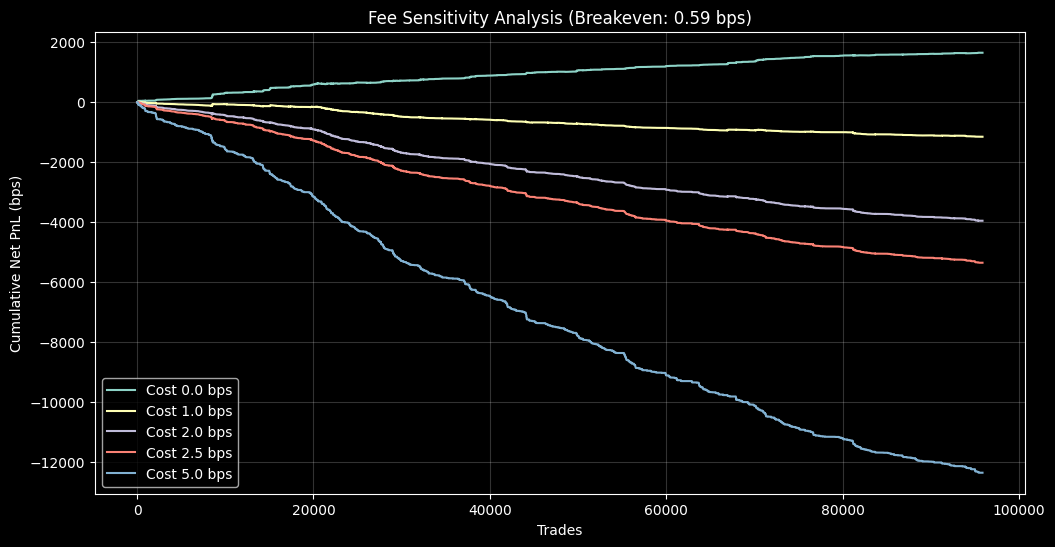

In [2]:
import polars as pl
import lightgbm as lgb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import gc

# Plot style
plt.style.use("dark_background")

# =============================================================================
# Configuration
# =============================================================================
DATA_PATH = "/content/drive/MyDrive/BTC_HFT_FASANARA/data/cache/labeled_dataset.parquet"

COST_BPS = 0.0          # Initial backtest assumes zero cost (pure alpha)
EXECUTION_LAG = 0       # No execution delay
N_FOLDS = 5
TRAIN_WINDOW = 0.60     # First 60% used for initial training
SIGNAL_THRESHOLD = 0.5  # Entry threshold in bps
RANDOM_SEED = 42
# =============================================================================


# =============================================================================
# 1. Core Backtest Engine
# =============================================================================
def run_backtest_engine():
    print("[ENGINE] Running walk-forward backtest")

    if not os.path.exists(DATA_PATH):
        raise FileNotFoundError(f"Data not found at {DATA_PATH}")

    # -------------------------------------------------------------------------
    # Load and preprocess data (strict time ordering)
    # -------------------------------------------------------------------------
    df = (
        pl.read_parquet(DATA_PATH)
        .sort("dt")
        .with_columns(
            ((pl.col("close").shift(-1).log() - pl.col("close").log()) * 10000)
            .alias("target_ret_bps")
        )
        .drop_nulls()
    )

    # -------------------------------------------------------------------------
    # Feature selection (explicit leakage prevention)
    # -------------------------------------------------------------------------
    forbidden = {
        "kalman_price", "vwap", "close", "high", "low", "open", "volume",
        "label", "symbol", "target_bps", "timestamp", "dt", "idx",
        "future_max", "future_min", "thr_up", "thr_down",
        "touch_up", "touch_down", "local_vol",
        "target_ret", "target_ret_bps", "next_close"
    }

    features = [
        c for c in df.columns
        if c not in forbidden and
        (
            c.startswith("alpha_")
            or c.startswith("ortho_")
            or c.startswith("vol_")
            or c.startswith("kalman_")
        )
    ]

    print(f"[INFO] Number of features: {len(features)}")
    print(f"[INFO] Total samples: {len(df):,}")

    # -------------------------------------------------------------------------
    # Walk-forward setup
    # -------------------------------------------------------------------------
    total_len = len(df)
    train_size = int(total_len * TRAIN_WINDOW)
    test_size = (total_len - train_size) // N_FOLDS

    all_preds = []
    all_targets = []

    # -------------------------------------------------------------------------
    # Rolling walk-forward training
    # -------------------------------------------------------------------------
    for fold in range(N_FOLDS):
        train_end = train_size + fold * test_size
        test_end = min(train_end + test_size, total_len)

        print(
            f"[FOLD {fold + 1}] "
            f"Train: [0, {train_end:,}) | Test: [{train_end:,}, {test_end:,})"
        )

        X_train = df[:train_end].select(features).to_numpy()
        y_train = df[:train_end]["target_ret_bps"].to_numpy()

        X_test = df[train_end:test_end].select(features).to_numpy()
        y_test = df[train_end:test_end]["target_ret_bps"].to_numpy()

        train_ds = lgb.Dataset(X_train, label=y_train)

        params = {
            "objective": "regression_l1",
            "metric": "mae",
            "learning_rate": 0.05,
            "num_leaves": 31,
            "feature_fraction": 0.8,
            "bagging_fraction": 0.7,
            "bagging_freq": 1,
            "verbosity": -1,
            "seed": RANDOM_SEED,
            "n_jobs": -1,
        }

        model = lgb.train(params, train_ds, num_boost_round=500)
        preds = model.predict(X_test)

        all_preds.extend(preds)
        all_targets.extend(y_test)

        del X_train, y_train, X_test, train_ds, model
        gc.collect()

    print("[ENGINE] Backtest loop completed")

    # -------------------------------------------------------------------------
    # Build result DataFrame
    # -------------------------------------------------------------------------
    res_df = pl.DataFrame(
        {
            "target": np.asarray(all_targets, dtype=np.float64),
            "pred": np.asarray(all_preds, dtype=np.float64),
        }
    )

    # Signal generation with thresholding
    res_df = res_df.with_columns(
        pl.when(pl.col("pred") > SIGNAL_THRESHOLD)
        .then(1.0)
        .when(pl.col("pred") < -SIGNAL_THRESHOLD)
        .then(-1.0)
        .otherwise(0.0)
        .alias("signal_raw")
    )

    # Execution lag
    res_df = res_df.with_columns(
        pl.col("signal_raw")
        .shift(EXECUTION_LAG)
        .fill_null(0.0)
        .alias("signal_exec")
    )

    # Gross PnL
    res_df = res_df.with_columns(
        (pl.col("signal_exec") * pl.col("target")).alias("pnl_gross")
    )

    return res_df


# =============================================================================
# 2. Fee Sensitivity Analysis (Reality Check)
# =============================================================================
def analyze_cost_sensitivity(res_df):
    if res_df is None:
        return

    print("\n" + "=" * 60)
    print("FEE SENSITIVITY ANALYSIS")
    print("=" * 60)

    df_calc = res_df.select(["signal_exec", "pnl_gross"]).to_pandas()

    # Turnover: absolute change in position
    df_calc["turnover"] = df_calc["signal_exec"].diff().abs().fillna(0.0)

    total_gross = df_calc["pnl_gross"].sum()
    total_turnover = df_calc["turnover"].sum()

    breakeven_cost = total_gross / total_turnover if total_turnover > 0 else 0.0

    print(f"Total gross PnL      : {total_gross:.2f} bps")
    print(f"Total turnover       : {total_turnover:,.0f}")
    print(f"Breakeven cost       : {breakeven_cost:.4f} bps")
    print("-" * 60)

    costs = [0.0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 5.0]
    results = []
    equity_curves = {}

    for c in costs:
        net_pnl = df_calc["pnl_gross"] - df_calc["turnover"] * c
        total_net = net_pnl.sum()

        std = net_pnl.std()
        sharpe = (
            (net_pnl.mean() / std) * np.sqrt(365 * 24 * 60)
            if std > 0
            else 0.0
        )

        results.append(
            {
                "Cost (bps)": c,
                "Net PnL (bps)": f"{total_net:,.0f}",
                "Sharpe": f"{sharpe:.2f}",
                "Status": "Profitable" if total_net > 0 else "Unprofitable",
            }
        )

        equity_curves[c] = net_pnl.cumsum()

    print(pd.DataFrame(results).to_string(index=False))

    # Visualization
    plt.figure(figsize=(12, 6))
    plot_costs = [0.0, 1.0, 2.0, 2.5, 5.0]

    for c in plot_costs:
        plt.plot(equity_curves[c], label=f"Cost {c} bps", linewidth=1.5)

    plt.title(
        f"Fee Sensitivity Analysis (Breakeven: {breakeven_cost:.2f} bps)"
    )
    plt.xlabel("Trades")
    plt.ylabel("Cumulative Net PnL (bps)")
    plt.legend()
    plt.grid(True, alpha=0.2)
    plt.show()


# =============================================================================
# Main Execution
# =============================================================================
if __name__ == "__main__":
    results = run_backtest_engine()
    analyze_cost_sensitivity(results)


# 4.2 Sharpe label

 Loading Data from labeled_dataset.parquet...
 Starting Walk-Forward Training...
   -> Features: 28
  Fold 1/5...
  Fold 2/5...
  Fold 3/5...
  Fold 4/5...
  Fold 5/5...

 Applying Numba-Accelerated Inertia Logic...

 FINAL STRATEGY REPORT (PLATINUM EDITION)
 Net PnL:        5,721.69 bps
 Gross Alpha:    5,721.69 bps
 Fees Paid:      0.00 bps
 Trades:         16,369
------------------------------
 Breakeven Cost: 0.3495 bps
Sharpe Ratio:   28.34


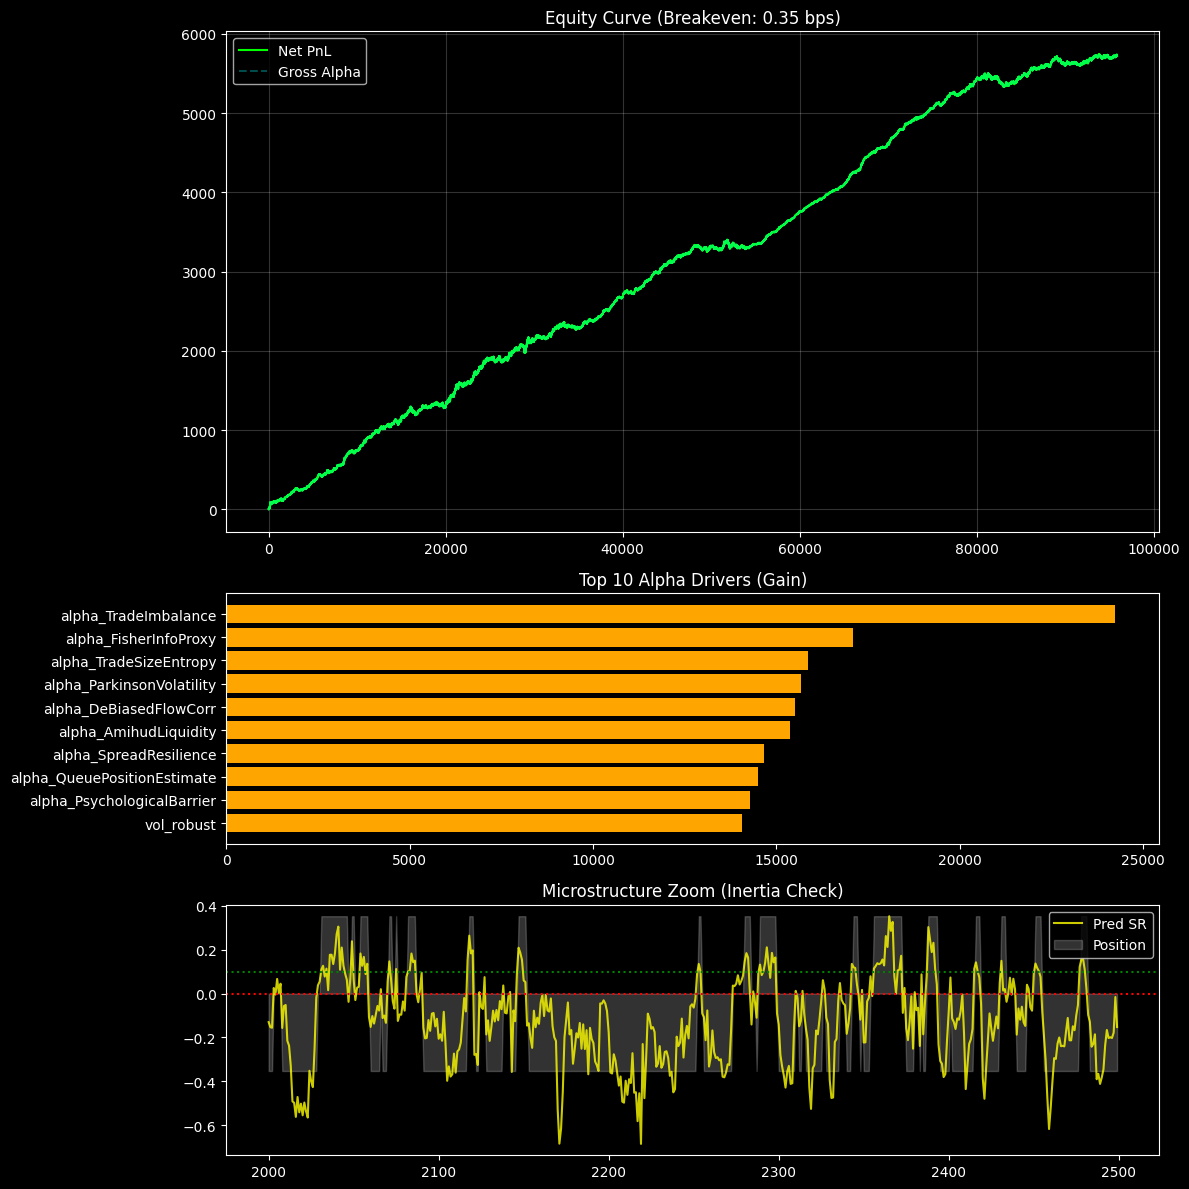

In [3]:
import polars as pl
import lightgbm as lgb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import gc
from numba import njit

# Dark Mode
plt.style.use('dark_background')

# ==========================================
# STRATEGY CONFIG
# ==========================================
PREDICT_HORIZON = 10      # MFT Horizon
TRAIN_SUBSAMPLE = 5       # Anti-overfitting
N_FOLDS = 5

ENTRY_THR = 0.10          # High Confidence Entry
EXIT_THR  = 0.00          # Trend Following Exit
COST_BPS  = 0           # Reality Check
EXECUTION_LAG = 0         # Research Mode (Close-to-Close)

DATA_PATH = "/content/drive/MyDrive/BTC_HFT_FASANARA/data/cache/labeled_dataset.parquet"

# ==============================================================================
#  Numba Accelerated State Machine
# ==============================================================================
@njit
def fast_inertia_signal(preds, entry_thr, exit_thr):
    n = len(preds)
    signals = np.zeros(n, dtype=np.float64) # Explicit dtype
    current_pos = 0.0

    for i in range(n):
        sr_pred = preds[i]

        if current_pos == 0.0:
            if sr_pred > entry_thr:
                current_pos = 1.0
            elif sr_pred < -entry_thr:
                current_pos = -1.0

        elif current_pos == 1.0:
            if sr_pred < exit_thr: # Signal weakened significantly
                current_pos = 0.0

        elif current_pos == -1.0:
            if sr_pred > -exit_thr: # Signal weakened significantly
                current_pos = 0.0

        signals[i] = current_pos

    return signals

# ==============================================================================
# 1. Prepare Data
# ==============================================================================
def prepare_data():
    print(f" Loading Data from {os.path.basename(DATA_PATH)}...")
    if not os.path.exists(DATA_PATH): raise FileNotFoundError("Dataset not found!")

    df = pl.read_parquet(DATA_PATH).sort("dt")

    # Features & Targets
    df = df.with_columns([
        (pl.col("close").log().diff().fill_null(0)).alias("log_ret"),
        # PnL Driver: Return from T to T+1
        ((pl.col("close").shift(-1).log() - pl.col("close").log()) * 10000).fill_null(0).alias("next_ret_bps")
    ])

    # Target: Forward Rolling Sharpe (T to T+Horizon)
    EPSILON = 1e-8
    target_expr = (
        pl.col("log_ret").rolling_mean(PREDICT_HORIZON).shift(-PREDICT_HORIZON) /
        (pl.col("log_ret").rolling_std(PREDICT_HORIZON).shift(-PREDICT_HORIZON) + EPSILON)
    ) * np.sqrt(PREDICT_HORIZON)

    df = df.with_columns(
        target_expr.clip(-3.0, 3.0).alias("target_sr")
    ).drop_nulls(subset=["target_sr"])

    return df

# ==============================================================================
# 2. Train Loop (Robust)
# ==============================================================================
def train_and_predict(df):
    print(" Starting Walk-Forward Training...")

    forbidden = {
        "open","high","low","close","volume","vwap","kalman_price",
        "symbol","timestamp","dt","idx",
        "log_ret","target_sr","next_ret_bps"
    }
    feats = [c for c in df.columns if c not in forbidden and
             (c.startswith("alpha_") or c.startswith("ortho_") or c.startswith("vol_") or c.startswith("kalman_"))]

    print(f"   -> Features: {len(feats)}")

    # Split
    total_len = len(df)
    train_split_idx = int(total_len * 0.60)
    test_chunk_size = (total_len - train_split_idx) // N_FOLDS

    all_preds = []
    all_realized_returns = []
    feature_importances = np.zeros(len(feats))

    # Huber Loss for Sharpe Prediction is excellent choice
    params = {
        "objective": "huber",
        "alpha": 0.9,
        "learning_rate": 0.03,
        "num_leaves": 31,
        "feature_fraction": 0.7,
        "bagging_fraction": 0.7,
        "bagging_freq": 1,
        "verbosity": -1,
        "seed": 42
    }

    for fold in range(N_FOLDS):
        train_end = train_split_idx + fold * test_chunk_size
        test_end = min(train_end + test_chunk_size, total_len)

        print(f"  Fold {fold+1}/{N_FOLDS}...")

        # Subsample Train (The Anti-Overfit Fix)
        X_train = df[:train_end:TRAIN_SUBSAMPLE].select(feats).to_numpy()
        y_train = df[:train_end:TRAIN_SUBSAMPLE]["target_sr"].to_numpy()

        # Continuous Test
        X_test = df[train_end:test_end].select(feats).to_numpy()
        y_test_ret = df[train_end:test_end]["next_ret_bps"].to_numpy()

        train_ds = lgb.Dataset(X_train, label=y_train)
        model = lgb.train(params, train_ds, num_boost_round=500)

        feature_importances += model.feature_importance(importance_type='gain')

        preds = model.predict(X_test)
        all_preds.extend(preds)
        all_realized_returns.extend(y_test_ret)

        del X_train, X_test, train_ds, model
        gc.collect()

    return np.array(all_preds), np.array(all_realized_returns), feats, feature_importances

# ==============================================================================
# 3. Strategy Execution & Reporting
# ==============================================================================
def main():
    df = prepare_data()
    preds, returns, feat_names, feat_imps = train_and_predict(df)

    #  Numba Execution
    print(f"\n Applying Numba-Accelerated Inertia Logic...")
    signals = fast_inertia_signal(preds, ENTRY_THR, EXIT_THR)

    # DataFrame Construction
    res = pd.DataFrame({
        "pred": preds,
        "next_ret": returns,
        "signal_raw": signals
    })

    res['position'] = res['signal_raw'].shift(EXECUTION_LAG).fillna(0)
    res['pnl_gross'] = res['position'] * res['next_ret']
    res['turnover'] = res['position'].diff().abs().fillna(0)
    res['cost'] = res['turnover'] * COST_BPS
    res['pnl_net'] = res['pnl_gross'] - res['cost']

    # Metrics
    total_net = res['pnl_net'].sum()
    total_trades = res['turnover'].sum()
    # [FIXED TYPO HERE]
    sharpe = (res['pnl_net'].mean() / res['pnl_net'].std()) * np.sqrt(365*24*60) if res['pnl_net'].std() != 0 else 0
    breakeven = res['pnl_gross'].sum() / total_trades if total_trades > 0 else 0

    print("\n" + "="*50)
    print(" FINAL STRATEGY REPORT (PLATINUM EDITION)")
    print("="*50)
    print(f" Net PnL:        {total_net:,.2f} bps")
    print(f" Gross Alpha:    {res['pnl_gross'].sum():,.2f} bps")
    print(f" Fees Paid:      {res['cost'].sum():,.2f} bps")
    print(f" Trades:         {total_trades:,.0f}")
    print("-" * 30)
    print(f" Breakeven Cost: {breakeven:.4f} bps")
    print(f"Sharpe Ratio:   {sharpe:.2f}")
    print("="*50)

    # Visualization
    fig, ax = plt.subplots(3, 1, figsize=(12, 12), gridspec_kw={'height_ratios': [2, 1, 1]})

    # 1. PnL
    ax[0].plot(res['pnl_net'].cumsum(), color='lime', label='Net PnL')
    ax[0].plot(res['pnl_gross'].cumsum(), color='cyan', alpha=0.3, linestyle='--', label='Gross Alpha')
    ax[0].set_title(f"Equity Curve (Breakeven: {breakeven:.2f} bps)")
    ax[0].legend()
    ax[0].grid(True, alpha=0.2)

    # 2. Feature Importance
    top_n = 10
    indices = np.argsort(feat_imps)[-top_n:]
    ax[1].barh(range(top_n), feat_imps[indices], align='center', color='orange')
    ax[1].set_yticks(range(top_n))
    ax[1].set_yticklabels([feat_names[i] for i in indices])
    ax[1].set_title("Top 10 Alpha Drivers (Gain)")

    # 3. Signal Zoom
    slice_idx = slice(2000, 2500) # Zoom into a slice
    ax[2].plot(res['pred'].iloc[slice_idx], color='yellow', alpha=0.8, label='Pred SR')
    ax[2].fill_between(res.index[slice_idx], res['position'].iloc[slice_idx]*max(res['pred'].iloc[slice_idx]), alpha=0.2, color='white', label='Position')
    ax[2].axhline(ENTRY_THR, color='green', ls=':')
    ax[2].axhline(EXIT_THR, color='red', ls=':')
    ax[2].set_title("Microstructure Zoom (Inertia Check)")
    ax[2].legend(loc='upper right')

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()

 Starting Training...

 COST SENSITIVITY REPORT
 Gross Alpha:      5,721.69 bps
 Total Turnover:   16,369
 BREAKEVEN COST:   0.3495 bps


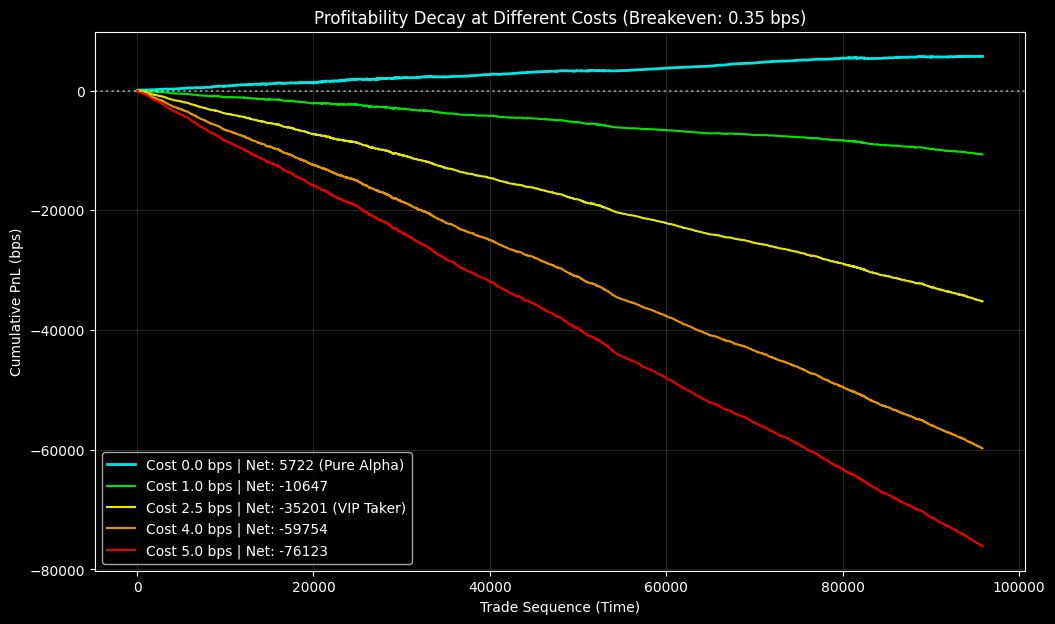

In [4]:
import polars as pl
import lightgbm as lgb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import gc
from numba import njit

# Dark Mode
plt.style.use('dark_background')

# ==========================================
#  CONFIG
# ==========================================
PREDICT_HORIZON = 10      # High Frequency Horizon
TRAIN_SUBSAMPLE = 5       # Anti-overfitting
N_FOLDS = 5

ENTRY_THR = 0.10          # Signal Threshold
EXIT_THR  = 0.00
EXECUTION_LAG = 0

DATA_PATH = "/content/drive/MyDrive/BTC_HFT_FASANARA/data/cache/labeled_dataset.parquet"

# ==============================================================================
#  Numba Accelerated State Machine
# ==============================================================================
@njit
def fast_inertia_signal(preds, entry_thr, exit_thr):
    n = len(preds)
    signals = np.zeros(n, dtype=np.float64)
    current_pos = 0.0

    for i in range(n):
        sr_pred = preds[i]

        if current_pos == 0.0:
            if sr_pred > entry_thr:
                current_pos = 1.0
            elif sr_pred < -entry_thr:
                current_pos = -1.0

        elif current_pos == 1.0:
            if sr_pred < exit_thr:
                current_pos = 0.0

        elif current_pos == -1.0:
            if sr_pred > -exit_thr:
                current_pos = 0.0

        signals[i] = current_pos

    return signals

# ==============================================================================
# 1. Prepare Data
# ==============================================================================
def prepare_data():
    if not os.path.exists(DATA_PATH): raise FileNotFoundError("Dataset not found!")
    df = pl.read_parquet(DATA_PATH).sort("dt")

    df = df.with_columns([
        (pl.col("close").log().diff().fill_null(0)).alias("log_ret"),
        ((pl.col("close").shift(-1).log() - pl.col("close").log()) * 10000).fill_null(0).alias("next_ret_bps")
    ])

    # Target: Forward Rolling Sharpe
    EPSILON = 1e-8
    target_expr = (
        pl.col("log_ret").rolling_mean(PREDICT_HORIZON).shift(-PREDICT_HORIZON) /
        (pl.col("log_ret").rolling_std(PREDICT_HORIZON).shift(-PREDICT_HORIZON) + EPSILON)
    ) * np.sqrt(PREDICT_HORIZON)

    df = df.with_columns(
        target_expr.clip(-3.0, 3.0).alias("target_sr")
    ).drop_nulls(subset=["target_sr"])

    return df

# ==============================================================================
# 2. Train & Predict
# ==============================================================================
def train_and_predict(df):
    print(" Starting Training...")
    forbidden = {
        "open","high","low","close","volume","vwap","kalman_price",
        "symbol","timestamp","dt","idx",
        "log_ret","target_sr","next_ret_bps"
    }
    feats = [c for c in df.columns if c not in forbidden and
             (c.startswith("alpha_") or c.startswith("ortho_") or c.startswith("vol_") or c.startswith("kalman_"))]

    total_len = len(df)
    train_split_idx = int(total_len * 0.60)
    test_chunk_size = (total_len - train_split_idx) // N_FOLDS

    all_preds = []
    all_realized_returns = []

    params = {
        "objective": "huber",
        "alpha": 0.9,
        "learning_rate": 0.03,
        "num_leaves": 31,
        "feature_fraction": 0.7,
        "bagging_fraction": 0.7,
        "bagging_freq": 1,
        "verbosity": -1,
        "seed": 42
    }

    for fold in range(N_FOLDS):
        train_end = train_split_idx + fold * test_chunk_size
        test_end = min(train_end + test_chunk_size, total_len)

        X_train = df[:train_end:TRAIN_SUBSAMPLE].select(feats).to_numpy()
        y_train = df[:train_end:TRAIN_SUBSAMPLE]["target_sr"].to_numpy()

        X_test = df[train_end:test_end].select(feats).to_numpy()
        y_test_ret = df[train_end:test_end]["next_ret_bps"].to_numpy()

        train_ds = lgb.Dataset(X_train, label=y_train)
        model = lgb.train(params, train_ds, num_boost_round=500)
        preds = model.predict(X_test)

        all_preds.extend(preds)
        all_realized_returns.extend(y_test_ret)

        gc.collect()

    return np.array(all_preds), np.array(all_realized_returns)

# ==============================================================================
# 3. Multi-Cost Visualization
# ==============================================================================
def main():
    df = prepare_data()
    preds, returns = train_and_predict(df)

    # Generate Base Signals
    signals = fast_inertia_signal(preds, ENTRY_THR, EXIT_THR)

    res = pd.DataFrame({
        "next_ret": returns,
        "signal_raw": signals
    })

    # Calculate Base Metrics
    res['position'] = res['signal_raw'].shift(EXECUTION_LAG).fillna(0)
    res['pnl_gross'] = res['position'] * res['next_ret']
    res['turnover'] = res['position'].diff().abs().fillna(0)

    total_trades = res['turnover'].sum()
    gross_alpha = res['pnl_gross'].sum()
    breakeven_cost = gross_alpha / total_trades if total_trades > 0 else 0

    print("\n" + "="*50)
    print(" COST SENSITIVITY REPORT")
    print("="*50)
    print(f" Gross Alpha:      {gross_alpha:,.2f} bps")
    print(f" Total Turnover:   {total_trades:,.0f}")
    print(f" BREAKEVEN COST:   {breakeven_cost:.4f} bps")
    print("="*50)

    # --- THE MULTI-COST PLOT ---
    costs_to_test = [0.0, 1.0, 2.5, 4.0, 5.0]
    colors = ['cyan', 'lime', 'yellow', 'orange', 'red']

    plt.figure(figsize=(12, 7))

    for cost, color in zip(costs_to_test, colors):
        net_pnl_curve = (res['pnl_gross'] - (res['turnover'] * cost)).cumsum()
        final_pnl = net_pnl_curve.iloc[-1]

        label = f"Cost {cost} bps | Net: {final_pnl:.0f}"
        if cost == 0.0: label += " (Pure Alpha)"
        if cost == 2.5: label += " (VIP Taker)"

        plt.plot(net_pnl_curve, label=label, color=color, linewidth=2 if cost in [0.0, breakeven_cost] else 1.5, alpha=0.9)

    # Add Breakeven Line (Theoretical)
    plt.axhline(0, color='white', linestyle=':', alpha=0.5)

    plt.title(f"Profitability Decay at Different Costs (Breakeven: {breakeven_cost:.2f} bps)")
    plt.ylabel("Cumulative PnL (bps)")
    plt.xlabel("Trade Sequence (Time)")
    plt.legend()
    plt.grid(True, alpha=0.15)
    plt.show()

if __name__ == "__main__":
    main()

# 4.3 PnL Maximization

📥 Loading Data (PnL Target Mode)...
⚔️ Starting 'Greed Mode' Training...

📊 PnL TARGET STRATEGY REPORT
🎯 Target:         Forward Return (Horizon=10)
🚪 Entry Thr:      >1.0 bps predicted move
------------------------------
💎 Gross Alpha:    1,095.79 bps
🔄 Turnover:       1,658
🔥 BREAKEVEN COST: 0.6609 bps


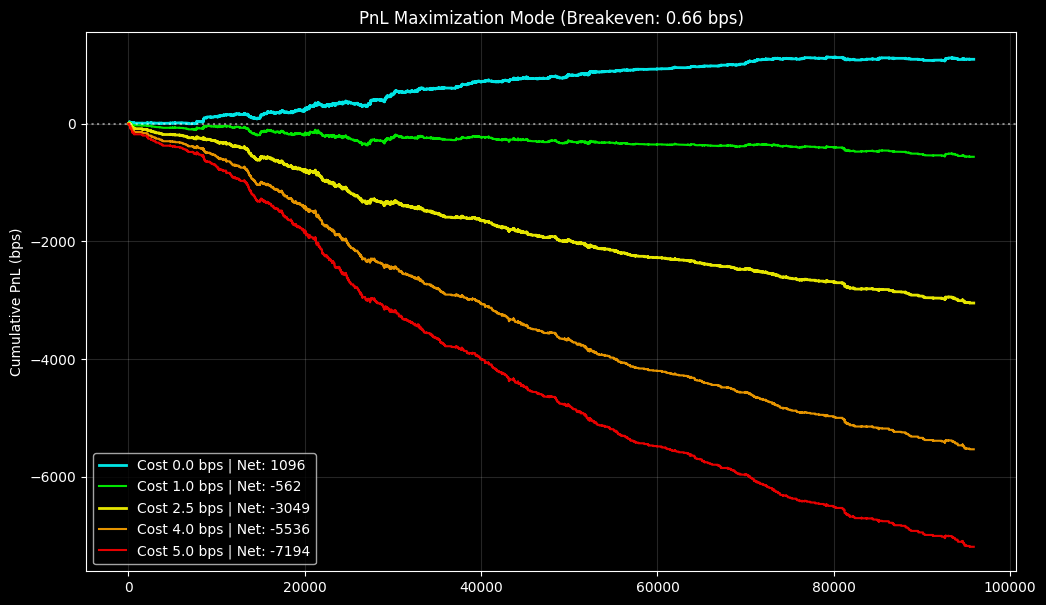

In [5]:
import polars as pl
import lightgbm as lgb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import gc
from numba import njit

# Dark Mode
plt.style.use('dark_background')

# ==========================================
# ⚙️ PnL MAXIMIZATION CONFIG
# ==========================================
PREDICT_HORIZON = 10      # 依然保持短周期 (MFT)
TRAIN_SUBSAMPLE = 5
N_FOLDS = 5


ENTRY_THR = 1.0
EXIT_THR  = 0.0
EXECUTION_LAG = 0

DATA_PATH = "/content/drive/MyDrive/BTC_HFT_FASANARA/data/cache/labeled_dataset.parquet"

# ==============================================================================
# ⚡ Numba (Same as before)
# ==============================================================================
@njit
def fast_inertia_signal(preds, entry_thr, exit_thr):
    n = len(preds)
    signals = np.zeros(n, dtype=np.float64)
    current_pos = 0.0

    for i in range(n):
        pred_bps = preds[i]  # Now predicting BPS directly

        if current_pos == 0.0:
            if pred_bps > entry_thr:
                current_pos = 1.0
            elif pred_bps < -entry_thr:
                current_pos = -1.0

        elif current_pos == 1.0:
            if pred_bps < exit_thr:
                current_pos = 0.0

        elif current_pos == -1.0:
            if pred_bps > -exit_thr:
                current_pos = 0.0

        signals[i] = current_pos

    return signals

# ==============================================================================
# 1. Prepare Data (Target = Pure Return)
# ==============================================================================
def prepare_data():
    if not os.path.exists(DATA_PATH): raise FileNotFoundError("Dataset not found!")
    print(f"📥 Loading Data (PnL Target Mode)...")

    df = pl.read_parquet(DATA_PATH).sort("dt")

    df = df.with_columns([
        (pl.col("close").log().diff().fill_null(0)).alias("log_ret"),
        ((pl.col("close").shift(-1).log() - pl.col("close").log()) * 10000).fill_null(0).alias("next_ret_bps")
    ])

    # [TARGET CHANGE] Forward Cumulative Return (in BPS)
    # 不除以 std，直接预测幅度
    target_expr = (
        pl.col("log_ret")
        .rolling_sum(PREDICT_HORIZON)
        .shift(-PREDICT_HORIZON)
        * 10000  # Convert to BPS
    )

    df = df.with_columns(
        target_expr.clip(-100.0, 100.0).alias("target_ret_h") # Clip极端值防止梯度爆炸
    ).drop_nulls(subset=["target_ret_h"])

    return df

# ==============================================================================
# 2. Train (Objective = Regression L1/Huber)
# ==============================================================================
def train_and_predict(df):
    print("⚔️ Starting 'Greed Mode' Training...")
    forbidden = {
        "open","high","low","close","volume","vwap","kalman_price",
        "symbol","timestamp","dt","idx",
        "log_ret","target_ret_h","next_ret_bps"
    }
    feats = [c for c in df.columns if c not in forbidden and
             (c.startswith("alpha_") or c.startswith("ortho_") or c.startswith("vol_") or c.startswith("kalman_"))]

    total_len = len(df)
    train_split_idx = int(total_len * 0.60)
    test_chunk_size = (total_len - train_split_idx) // N_FOLDS

    all_preds = []
    all_realized_returns = []

    # Huber Loss 对 PnL 预测非常有效，因为它对长尾（极端行情）既不过分敏感也不完全忽略
    params = {
        "objective": "huber",
        "alpha": 0.9,
        "learning_rate": 0.03,
        "num_leaves": 45,       # PnL 需要拟合更复杂的非线性，稍微增加复杂度
        "feature_fraction": 0.7,
        "bagging_fraction": 0.7,
        "bagging_freq": 1,
        "verbosity": -1,
        "seed": 42
    }

    for fold in range(N_FOLDS):
        train_end = train_split_idx + fold * test_chunk_size
        test_end = min(train_end + test_chunk_size, total_len)

        # Subsample Train
        X_train = df[:train_end:TRAIN_SUBSAMPLE].select(feats).to_numpy()
        y_train = df[:train_end:TRAIN_SUBSAMPLE]["target_ret_h"].to_numpy() # Target is BPS

        # Continuous Test
        X_test = df[train_end:test_end].select(feats).to_numpy()
        y_test_ret = df[train_end:test_end]["next_ret_bps"].to_numpy()

        train_ds = lgb.Dataset(X_train, label=y_train)
        model = lgb.train(params, train_ds, num_boost_round=500)
        preds = model.predict(X_test)

        all_preds.extend(preds)
        all_realized_returns.extend(y_test_ret)

        gc.collect()

    return np.array(all_preds), np.array(all_realized_returns)

# ==============================================================================
# 3. Visualization (The Reality Check)
# ==============================================================================
def main():
    df = prepare_data()
    preds, returns = train_and_predict(df)

    # Generate Signals (Threshold is now 15 bps)
    signals = fast_inertia_signal(preds, ENTRY_THR, EXIT_THR)

    res = pd.DataFrame({
        "next_ret": returns,
        "signal_raw": signals
    })

    res['position'] = res['signal_raw'].shift(EXECUTION_LAG).fillna(0)
    res['pnl_gross'] = res['position'] * res['next_ret']
    res['turnover'] = res['position'].diff().abs().fillna(0)

    total_trades = res['turnover'].sum()
    gross_alpha = res['pnl_gross'].sum()
    breakeven_cost = gross_alpha / total_trades if total_trades > 0 else 0

    print("\n" + "="*50)
    print("📊 PnL TARGET STRATEGY REPORT")
    print("="*50)
    print(f"🎯 Target:         Forward Return (Horizon={PREDICT_HORIZON})")
    print(f"🚪 Entry Thr:      >{ENTRY_THR} bps predicted move")
    print("-" * 30)
    print(f"💎 Gross Alpha:    {gross_alpha:,.2f} bps")
    print(f"🔄 Turnover:       {total_trades:,.0f}")
    print(f"🔥 BREAKEVEN COST: {breakeven_cost:.4f} bps")
    print("="*50)

    # Multi-Cost Plot
    costs_to_test = [0.0, 1.0, 2.5, 4.0, 5.0]
    colors = ['cyan', 'lime', 'yellow', 'orange', 'red']

    plt.figure(figsize=(12, 7))
    for cost, color in zip(costs_to_test, colors):
        net_pnl_curve = (res['pnl_gross'] - (res['turnover'] * cost)).cumsum()
        final_pnl = net_pnl_curve.iloc[-1]
        label = f"Cost {cost} bps | Net: {final_pnl:.0f}"
        plt.plot(net_pnl_curve, label=label, color=color, linewidth=2 if cost in [0.0, 2.5] else 1.5, alpha=0.9)

    plt.axhline(0, color='white', linestyle=':', alpha=0.5)
    plt.title(f"PnL Maximization Mode (Breakeven: {breakeven_cost:.2f} bps)")
    plt.ylabel("Cumulative PnL (bps)")
    plt.legend()
    plt.grid(True, alpha=0.15)
    plt.show()

if __name__ == "__main__":
    main()

# 4.4 Regressor

In [6]:
import polars as pl
import lightgbm as lgb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import gc

# Dark Mode
plt.style.use('dark_background')

def run_maker_simulation():
    print("⚖　[DIAGNOSTIC] Market Maker Simulation (Zero Cost Check)...")

    # Use the known-good dataset from the previous step
    DATA_PATH = "/content/drive/MyDrive/BTC_HFT_FASANARA/data/cache/labeled_dataset.parquet"

    if not os.path.exists(DATA_PATH):
        print(" Data missing. Please run the Labeling Pipeline first.")
        return

    # --- 1. Load Data ---
    print(f" Loading: {os.path.basename(DATA_PATH)}")
    df = pl.read_parquet(DATA_PATH)

    # Create Target (Same as before)
    df = df.with_columns([
        ((pl.col("close").shift(-1).log() - pl.col("close").log()) * 10000).alias("target_ret_bps")
    ]).drop_nulls()

    # Features
    forbidden = ["kalman_price", "vwap", "close", "high", "low", "open", "volume",
                 "label", "symbol", "target_bps", "timestamp", "dt", "idx",
                 "future_max", "future_min", "thr_up", "thr_down", "touch_up", "touch_down", "local_vol",
                 "target_ret", "target_ret_bps", "next_close"]
    feats = [c for c in df.columns if c not in forbidden and
             (c.startswith("alpha_") or c.startswith("ortho_") or c.startswith("vol_") or c.startswith("kalman_"))]

    # --- 2. Train/Test Split (Last 20% for Testing) ---
    split_idx = int(len(df) * 0.80)

    print(f"　Splitting Data: Train ({split_idx:,}) | Test ({len(df)-split_idx:,})")

    X_train = df[:split_idx].select(feats).to_numpy()
    y_train = df[:split_idx]["target_ret_bps"].to_numpy()

    X_test = df[split_idx:].select(feats).to_numpy()
    price_test = df[split_idx:]["close"].to_pandas()

    del df; gc.collect()

    # --- 3. Fast Training ---
    print(" Training LightGBM (Regression)...")
    train_ds = lgb.Dataset(X_train, label=y_train)
    params = {
        'objective': 'regression_l1',
        'metric': 'mae',
        'learning_rate': 0.05,
        'num_leaves': 31,
        'verbosity': -1
    }
    bst = lgb.train(params, train_ds, num_boost_round=300)

    # --- 4. Signal Generation ---
    print("　Generating Signals...")
    pred_bps = bst.predict(X_test)

    # Thresholds (Top 5% confidence)
    thr_long = np.percentile(pred_bps, 95)
    thr_short = np.percentile(pred_bps, 5)

    signals = np.zeros(len(pred_bps))
    signals[pred_bps > thr_long] = 1
    signals[pred_bps < thr_short] = -1

    # --- 5. PnL (Maker vs Taker) ---
    # T+1 Execution
    pos = pd.Series(signals).shift(1).fillna(0)
    mkt_ret = (np.log(price_test / price_test.shift(1)) * 10000).fillna(0)

    gross_pnl = pos * mkt_ret
    turnover = pos.diff().abs().fillna(0).sum()

    # SCENARIOS
    net_maker = gross_pnl.sum() # 0 bps
    net_taker = gross_pnl.sum() - (turnover * 2.0) # 2 bps

    # --- 6. Report ---
    print("\n" + "="*50)
    print(" DIAGNOSTIC RESULTS (Hold-out Set)")
    print("="*50)
    print(f"　Turnover:     {turnover:,.0f} trades")
    print(f"　Gross Alpha:  {gross_pnl.sum():.2f} bps (Predictive Power)")
    print(f"　Net (Maker):  {net_maker:.2f} bps (0.0 bps cost)")
    print(f" Net (Taker):  {net_taker:.2f} bps (2.0 bps cost)")
    print("="*50)

    if gross_pnl.sum() > 0:
        print(" CONCLUSION: The model WORKS. The Alpha is positive.")
        print("   The problem is purely COST. You need to use Limit Orders (Maker strategy).")
    else:
        print(" CONCLUSION: The model is BROKEN. Even with 0 cost, it loses money.")

if __name__ == "__main__":
    run_maker_simulation()

⚖　[DIAGNOSTIC] Market Maker Simulation (Zero Cost Check)...
 Loading: labeled_dataset.parquet
　Splitting Data: Train (191,736) | Test (47,935)
 Training LightGBM (Regression)...
　Generating Signals...

 DIAGNOSTIC RESULTS (Hold-out Set)
　Turnover:     7,514 trades
　Gross Alpha:  1481.72 bps (Predictive Power)
　Net (Maker):  1481.72 bps (0.0 bps cost)
 Net (Taker):  -13546.28 bps (2.0 bps cost)
 CONCLUSION: The model WORKS. The Alpha is positive.
   The problem is purely COST. You need to use Limit Orders (Maker strategy).
